# Abstract
Causal inference under Pearl’s framework of structural causal models has been the subject of intense theoretical study, but performant open-source implementations of many of the key algorithms are still lacking or, where they exist, are not widely adopted or maintained. I present a performant implementation of Shpitser’s IDC algorithm for identification of conditional causal effects in semi-Markovian causal models.

# Executive Summary

Causal inference is a fundamental task in many fields, including epidemiology, economics, and data science. One popular framework for causal inference is Pearl's structural causal modeling framework, which utilizes directed acyclic graphs (DAGs) and the do-calculus to explicitly model potential causal relationships. This approach allows for a clear and intuitive representation of causal assumptions, while also helping to avoid common biases that can arise with other methodologies. However, a crucial step in this framework is identification: translating a causal question into an abstract statistical estimator that can be estimated using a combination of a model and parametric assumptions.

One important algorithm for identification in the structural causal modeling framework is Shpitser's algorithm for conditional interventional effects. This algorithm is polynomial time and guarantees a result when one is possible. However, existing open-source implementations of this algorithm are often incorrect, slow, or unmaintained. In this paper, I present a novel implementation of Shpitser's algorithm, written in Rust for efficient cross-functional use. Our implementation is production-quality code and includes extensive testing routines to ensure performance and correctness.

To bridge the gap between theoretical algorithm and practical tool, I developed two techniques as subroutines to the algorithm. I developed and implemented a heuristic symbolic simplification algorithm. To protect the speed and memory efficiency of the program, I designed a memory-sharing graph datastructure which allows similar graphs to share memory via a system of references and immutable data. Further, I am close to finishing an implementation of a estimation technique which will extend the work in Brule (2018).

To aid in adoption of this algorithm, I designed and implemented a user-friendly Python wrapper. This wrapper allows for the specification and visualization of causal graphs using a concise and elegant API, as well as giving the user full access to the underlying algorithms. This is available as a Python package on PyPi, and I created a website with documentation.

# Overview

The paper is organized as follows: in the first section, I provide an overview of the background and motivation behind the algorithm. I review the literature on available implementations of the algorithm and justify the need for this implementation.

In the Implementation section, I describe technical insights I employed and analysis I performed on my implementation. I detail techniques I developed for simplication and memory-sharing, and I describe the extensive testing procedures I used to ensure correctness. I describe the Python wrapper I developed to make the algorithm accessible to a wider audience. I evaluate my implementation on correctness, performance, and ease of use.

In Next Steps, I outline plans to complete this project before the final deadline. In Examples, I provide examples to demonstrate the utility of our implementation.

Appendices include HC/LO footnotes, documentation, and code.

## Contributions

In this work, we present a novel implementation of Shpitser's ID algorithm, including a comprehensive set of graph routines and a heuristic-based simplification algorithm. The implementation is written in Rust and the code is provided in the appendix. Additionally, we have developed Python bindings to facilitate usage of the algorithm. It is important to note that while this implementation and techniques for simplification and memory-sharing are novel, the underlying algorithm and all the material covered in the Background section is not a contribution of this paper and is instead a summary of the current state of the field.

## Links

- Documentation: [https://leo-ware.github.io/pqp/index.html](https://leo-ware.github.io/pqp/index.html)
- Source code: [https://github.com/leo-ware/pqp](https://github.com/leo-ware/pqp)
- PyPI Distribution: [https://pypi.org/project/pqp/](https://pypi.org/project/pqp/)

## Note on this text

AI text generation algorithms were used in the production of this text. Specifically, the OpenAI model ChatPGT was used extensively to edit for tone and concision.

# Background

## Structural Causal Models

### Overview

Structural Causal Models (SCM) provide a framework for modeling the generating process of a distribution. A structural causal model has four components: a set of observed variables $\textbf{V} = {v_1, v_2, ..., v_n}$, a set of unobserved variables $\textbf{U} = {u_1, u_2, ..., u_m}$, a distribution $P(U)$ over unobserved variables, and a set of functions $\textbf{F} = {f_1, f_2...f_n}$ such that each $f_i$ is a function from a subset of $\textbf{U} \cup \textbf{V} \backslash V_i$ to $v_i$. The arguments to $f_i$ are called the parents of $v_i$ or $pa(v_i)$ and they uniquely determine the value of $v_i$. Together, $P(\textbf{U})$ and $\textbf{F}$ induce $P(\textbf{V})$, a distribution over $\textbf{V}$.

We represent the causal assumptions in an SCM via a causal diagram. This is a directed acyclic graph (DAG) where each node corresponds to a variable in the model. A directed edge from $x_i$ to $x_j$ indicates that the value of $x_j$ depends on the value of $x_i$, or $x_i \in pa(x_j)$. To ensure the validity of an SCM, we restrict the set of valid models to those that can be represented by acyclic graphs, to prevent circular definitions between variables [1]. Algebraically, we can interpret a causal diagram as defining a set of conditional independence assumptions. In particular, as the parents of $v_i$ completely determine its value, $v_i$ will be independent of every other variable in the model, conditional on its parents.

Note the acyclicity assumption does not restrict the class of distributions that can be represented by an SCM because by the definition of joint probability any joint distribution $P(x_1, x2…x_n)$ can be factorized as $P(x_1 | x_2…x_n)P(x_2 | x_3…x_n)...P(x_n-1 | x_n) P(x_n)$. But, this can be represented as an SCM where $pa(x_i) = \{x_{i+1}, x_{i+2}…x_n\}$ without violating the acyclicity assumption. However, the any given causal graph may be consistent with only a subset of all possible distributions over the variables in the graph.

For the purposes of this paper, we make the additional assumption that each unobserved variable is the parent of at most two observed variables. This simplifies the graphical representation by replacing each unobserved variable and its outgoing edges with a single undirected edge connecting its two children. This can be interpreted as representing potential confounding between the two variables. An example of such a simplified graph is shown in Figure 1.

**Figure 1. Using Bidirected Edges to Represent Confounding**
![](2023-01-14-13-06-10.png)
*This figure shows an unobserved variable $C$ with two children being replaced with a bidirected, dashed edge. The bidirected edge represents the same information as $C$ did in the first diagram, but it is only possible to represent confounders with bidirected edges if they have exactly two children.*

### Conditional Independence Properties of Causal Diagrams

One of the key properties of causal diagrams is that they can provide insight into the conditional independence properties of a distribution $P(\textbf{U} \cup \textbf{V})$. As previously discussed, a variable $v_i$ is independent of all other variables in the model, conditional on its parents. This concept of a "flow of dependence" along edges connecting a node to its parent is a useful tool for understanding the conditional independence assumptions encoded in a causal diagram.

However, it is important to note that dependence does not flow along every path in the diagram. Paths can be blocked by conditioning on certain variables, which alters the conditional independence properties of the distribution. We can view a path as a collection of vertices, each of which must have one of the following forms:

$$X \leftarrow Y \leftarrow Z$$
$$X \rightarrow Y \rightarrow Z$$
$$X \leftarrow Y \rightarrow Z$$
$$X \rightarrow Y \leftarrow Z$$

In the first three cases, dependence will flow through the vertex as long as we do not condition on $Y$. In this case, we call the vertex unblocked. Conditioning on $Y$ blocks the path and prevents dependence from traveling along it. This means that, as long as this is the only path connecting $X$ and $Y$, the causal diagram is predicting that $X$ and $Z$ will be independent conditional on $Y$.

The third case, known as a collider, is slightly different. The last vertex will be unblocked if and only if we condition on $Y$.

To illustrate the concept of colliders, consider the example of college admissions. Without knowledge of whether a student was admitted, learning her SAT scores tells us nothing about her admissions essays. However, if we know that the student was admitted, and we observe that her SAT scores were low, we can infer that her essays must have been good.

A path is considered blocked if any vertex along it is blocked. If, after conditioning on a set of variables $\textbf{Z}$, there are no unblocked paths connecting two variables $v_i$ and $v_j$, then the model predicts that $v_i$ and $v_j$ are independent conditional on $\textbf{Z}$. In this case, we say that $v_i$ and $v_j$ are d-separated by $\textbf{Z}$. This concept of d-separation provides a means to connect the ideas of statistical association in the joint distribution with properties of the graph, and allows us to use graphical models of causal relationships to make testable predictions about datasets.

**Figure 2. Examples of D-Separation**

![](2023-01-14-13-52-24.png)

*The figure shows an example of a causal graphical model. Nodes represent random variables, and edges represent direct causal influence.*

For example, in figure 2 we can make the following predictions about distribution $P(\textbf{V})$ based on the causal diagram:

- $A \perp\!\!\!\!\perp C$ but not $A \perp\!\!\!\!\perp C | D$
- $A \perp\!\!\!\!\perp B | C$ but not $A \perp\!\!\!\!\perp B | C, D$
- $B \perp\!\!\!\!\perp D | C$ but not $B \perp\!\!\!\!\perp D$

### Graph Surgery and Causal Effects

In causal inference, a fundamental task is to measure the causal effect of one set of variables, $X$, on another, $Y$. To operationalize this task within the Structural Causal Model (SCM) framework, we utilize the concept of interventions. Specifically, in the SCM, the values of $X$ are determined by its parents, $pa(X)$. However, we are interested in understanding the effect of altering the value of $X$ through intervention, rather than allowing it to be set by its natural causes. To model this intervention process, we perform "graph surgery" by cutting all incoming edges into $X$, and examining the resulting interventional distribution. This allows us to isolate any remaining conditional effect of $X$ on $Y$, which can then be interpreted as a causal effect.

To gain further insight into this process, we can consider two types of paths that may connect $X$ and $Y$: backdoor paths and frontdoor paths. Backdoor paths are those that connect to $X$ through its parents, while frontdoor paths connect through its children. These paths represent different mechanisms through which $X$ may affect $Y$; frontdoor paths indicate direct causal effects, while backdoor paths indicate indirect effects through other variables (i.e. confounding). By performing graph surgery and cutting all backdoor paths, we effectively isolate any causal effects flowing through frontdoor paths.


### The Do-Calculus

In the Structural Causal Model (SCM) framework, causal queries are represented by the use of the "do-operator." The do-operator is indicated by its placement behind the conditioning bar in a probability expression, and it represents a modification of the underlying generating process. To illustrate, for sets of variables $X$, $Y$, and $Z$, the expression $P(Y | do(X), Z)$ represents the conditional probability $P(Y | X, Z)$ in the model that results from performing graph surgery on $X$. This represents a hypothetical scenario in which $X$ is fixed through intervention, rather than being determined by "nature." A "do-expression" is any probability expression containing the do-operator.

Both the average treatment effect (ATE) and the conditional average treatment effect (CATE) can be expressed in terms of do-expressions. The ATE is given by:

$ATE = E(P(y | do(x = 1))) - E(P(y | do(x = 0)))$

while the CATE is given by:

$CATE = E(P(y | z, do(x = 1))) - E(P(y | z, do(x = 0)))$

The manipulation of do-expressions is facilitated by Pearl's "do-calculus", which references properties of the model in which the do-expression is evaluated. The do-calculus provides conditions under which do-operators can be removed from an expression or replaced with conditioning. This is advantageous because it allows us to transform do-expressions, which cannot be estimated from the data, into traditional statistical estimands (e.g., $P(Y | X, Z)$), which can be estimated using parametric assumptions.

$
\textbf{Rule 1 } \text{Insertion/deletion of observations:}\\
P(Y | do(X), Z, W) = P(Y | do(X), W) \\
\text{if } (Y \perp\!\!\!\!\perp Z | X, W)_{G_{\overline{X}}}
$

$
\textbf{Rule 2 } \text{Action/observation interchange:}\\
P(Y | do(X), do(Z), W) = P(Y | do(X), Z, W) \\
\text{if } (Y \perp\!\!\!\!\perp Z | X, W)_{G_{\overline{X} \underline{Z}}}
$

$
\textbf{Rule 3 } \text{Insertion/deletion of actions:}\\
P(Y | do(X), do(Z), W) = P(Y | do(X), W) \\
\text{if } (Y \perp\!\!\!\!\perp Z | X, W)_{G_{\overline{X} \overline{Z(W)}}}
$

The task of removing the do-operators from a do-expression and turning it into a statistical estimand is called "identification." It is a crucial step in the process of causal inference in the SCM framework. General procedures for identification allow us to express causal queries in the rich language of do-expressions and then algorithmically translate these queries into statistical estimands that can be directly estimated from the data. Additionally, because identification does not make any parametric assumptions about the data, it allows us to decouple our causal assumptions from our parametric assumptions during modeling.

### The Four Stages of Causal Inference

Structured causal effect estimation is a four-step process consisting of modeling, identification, estimation, and robustness checks.

1. Modeling: This step involves identifying plausible causal relationships in the form of a directed acyclic graph (DAG). The DAG serves as a representation of the causal structure of the system being studied.

2. Identification: Once the causal structure is represented in the form of a DAG, the next step is to translate a causal query into an abstract estimator in the context of these assumptions. This process is known as identification, and it is a crucial step in the process of causal inference.

3. Estimation: After the abstract estimator has been derived, the next step is to add parametric assumptions and pick a specific model to represent the abstract estimator. This model is then fitted to the data, and an estimate of the causal effect is extracted.

4. Robustness checks: The final step is to assess the robustness of the analysis to the specifics of the assumptions made in the modeling process. This is done by perturbing the assumptions of the modeling process and determining the sensitivity of the analysis to these perturbations. These robustness checks are important for ensuring the validity and generalizability of the causal estimates.

It's important to note that the modeling, identification, estimation and robustness checks are interrelated, and that making progress in one step may require revisiting the others.

## The Problem of Identification

### Overview

It is important to note that not every causal estimand can be unambiguously estimated in every model. Identification, or the process of determining the causal estimand from the joint distribution, may fail when it is impossible to unambiguously determine $P(Y | do(X))$ from $P$. Identification is always possible in a graph with no confounding, but in some cases it is not possible because it is not possible to disentangle the effect from possible confounding. For example, in a model with a bidirected edge between variables, it may be impossible to identify $P(Y | do(X))$ because any observed effect could be explained by confounding along the bidirected edge, and there is no way to control for this.

**Figure 4. The Bow Graph**

![](2023-01-14-14-22-06.png)

*The bow graph is the simplest example of a graph with a non-identifiable interventional distribution.*

The rules of the do-calculus provide complete conditions for identification of causal estimands; if it is possible to convert the causal estimand to a statistical estimand, then it is possible using the do-calculus. However, manually applying the rules of the do-calculus to derive an abstract estimator is time-consuming and requires the researcher to make reference to complex properties of the causal graph, which is a task humans are ill-suited to, especially as the complexity of the graph grows. In the general case, it is too complex a task to be performed by hand.

Thus, it is necessary to find algorithms by which identification can be performed automatically. This is a nontrivial problem; naive approaches often have exponential time complexity in the size of the graph, and the best algorithms, while polynomial time, rest on complex graph theory.

Some researchers have simplified this problem by sidestepping direct application of the do-calculus and instead using the concept of adjustment sets. These methods rely on finding a set of variables which, when controlled for, block all backdoor-paths from the intervention set to the outcome set. However, these approaches face two distinct challenges. First, naive approaches to adjustment set search, such as those implemented in Knupple (2010), Breitling (2010), and Sharma (2020) rely on enumerating the set of all possible adjustment sets and then checking whether each successfully blocks all backdoor paths. This is an issue because the number of possible adjustment sets grows exponentially in the number of nodes in the graph. This makes these approaches infeasible for even fairly small graphs.

More efficient algorithms exist for adjustment set search, such as the one proposed in Textor and Liskiewicz (2011), which works in polynomial time. However, the drawback of these algorithms is that although every valid adjustment set corresponds to a valid statistical estimator for the query, not every valid statistical estimator can be represented as an adjustment set. Because these algorithms are only searching among adjustment sets, they fail in cases where other classes of estimator are needed.

To illustrate, in the famous front-door model, the interventional distribution $P(Y | do(X))$ is identified by the simple statistical estimator $P(Y | do(X)) = \sum_z P(Z | X) \sum_x P(Y | Z, X) P(X)$. This estimator works by breaking the problem into two subproblems: first identifying the interventional distributions $P(M | do(X))$ and $P(Y | do(M))$ and then combining these to identify $P(Y | do(X))$. Each subproblem can be solved using an adjustment set operator, but there is no adjustment set estimator which identifies $P(Y | do(X))$.

### C-components

Front-door estimation is an interesting technique, but it also illustrates a larger concept in causal inference known as c-component factorization. C-components, or connected components, are subsets of the graph that are connected via bidirectional (confounding) edges. Two nodes, $A$ and $B$, in a causal graph are in the same c-component if and only if there is a path from $A$ to $B$ that only follows bidirectional edges. It has been shown that any causal graph can be uniquely partitioned into a minimal set of c-components (Tian, 2002).

More importantly, Tian (2002) showed that for any c-component $C$ in a graph $G$, the interventional distribution $P(C | do(V \backslash C))$ is identifiable, where $V$ denotes the set of nodes in $G$ and $\backslash$ represents set difference. This means that the problem of identifying $P(Y | do(X))$ can be broken down into a set of subproblems, one for each c-component in the graph $G \backslash X$. This is the first critical insight that enables efficient identification and is known as c-component factorization.

C-components also allow for the introduction of more complex graphical structures, such as the c-tree. A $Y$-rooted c-tree is a graph $G$ that contains both directed and bidirected edges, where the entire graph is a single c-component and every node has at most one child. Additionally, there is a single node $Y$ that has no children. If there are multiple nodes with no children, these nodes are referred to as the root-set of $G$, and the graph is called a c-forest.

**Figure 4. A C-Tree and  C-Forest**

![](2023-01-14-15-01-52.png)

*This figure shows a c-tree (left) and a c-forest (right). Note that both are c-components because they are completely connected by bidirectional edges. In addition, in both, no node has more than one child. However, in the c-tree, C is the only node without children. This makes this a $C$-rooted c-tree. On the other hand, the graph on the right has two nodes without children: $C$ and $G$. This makes it a $\{C, G\}$-rooted c-forest.*

By utilizing c-forests, the concept of a hedge can be defined. Hedges are graphical structures that prevent the identification of interventional distributions. In a causal graphical model with graph $G$, if an interventional distribution $P(Y | do(X))$ is sought for two sets of random variables $X$ and $Y$, and if there exist two subgraphs $F$ and $F'$ such that the intersection of $F$ and $X$ is non-empty, but the intersection of $F'$ and $X$ is empty, and if $F'$ is a subgraph of $F$, and both form $Z$-rooted c-forests, where $Z$ is a subset of $Y$, the interventional distribution $P(Y | do(X))$ will be identifiable if and only if such $F$, $F'$, and $Z$ do not exist.

In other words, if two nested c-forests are found, where at least some elements from $Y$ are in their root set, and the smaller one does not contain any elements from $X$ but the bigger one does, the interventional distribution is not identifiable.

### Shpitser's Algorithm

Shpitser’s ID algorithm exploits the properties of c-components to identify interventional distributions. It is polynomial time and can always derive an estimator if one exists. The algorithm works as follows (Shpitser, 2008):

$
\text{function }\textbf{ID}(y, x, P, G)\\
\text{INPUT: x, y value assignments, P a probability distribution, G a causal diagram}\\
\text{OUTPUT: Expression for } P_x(y) \text{in terms of } P \text{ or } \textbf{FAIL}
$

$
\text{1. if } x = \emptyset \text{ return } \sum_{v \setminus y} P(v)\\ \\
$

$
\text{2. if } V \setminus An(Y)_G \ne \emptyset \\ \text{ return } \textbf{ID}(y, x \cap An(Y)_G, \sum_{v \setminus An(Y)_G} P, G_{An(Y)})
$

$
\text{3. let } W = (V \setminus X) \setminus An(Y)_{G_{\overline{x}}} \\
\text{if } W \ne \emptyset \text{, return } \textbf{ID}(y, x\cup w, P, G)
$

$
\text{4. if } C(G \setminus X) = {S_1...S_k}\\
\text{return } \sum_{v \setminus (y \cup x)} \prod_{i} \textbf{ID}(s_i, v \setminus s_i, P, G)
$

If line 4 does not return, then $C(G \setminus X) = {S}$

$
\text{5. if } C(G) = {G} \text{, throw } \textbf{FAIL}
$

$
\text{6. } S \isin C(G) \text{ return } \sum_{s \setminus y}\prod_{ \{i | V_i \subset S \} } P(v_i | v_\pi^{(i - 1)})
$

$
\text{7. if } (\exists S') S \subset S' \in C(G) \\
\text{ return } \textbf{ID}(y, x \cap S', \prod_{ \{i | V_i \subset S' \} }P(V_i | V_\pi^{(i - 1)} \cap S', v_\pi^{(i - 1)} \setminus S'), G_{S'})
$

The first three lines set up the algorithm. Line one is a base-case for identifiability. Lines two and three perform simplification.

Line four works by breaking up the identification problem into subproblems. Considering the subgraph $G’ = G \setminus X$, we find the c-components $\{s_i\}$ of $G’$. If there is more than one, then we can identify $P(Y | do(X))$ by finding the interventional distribution $P(s_i | do(G \ s_i))$ for each $s_i$. Because of c-component factorization, we know that all such terms will be identifiable if and only if $P(Y | do(X))$ is identifiable. We can then take the product of all such terms to get a joint interventional distribution over the nodes in $G’$. By marginalizing all variables other than those in $X$ and $Y$, we can identify the interventional distribution.
 
After repeated application of the above step, we will be in a position where $G’$ consists of a single c-component. There are three possible ways in which $X$ could relate to $G’$. $X$ and $G’$ could together form a single c-component. In this case, we have discovered a hedge, proving the interventional distribution is not identifiable (line 5). There could be no bidirectional edges connecting elements of $G’$ to elements of $X$. In this case, there are no backdoor paths from $X$ to $G’$ and we can identify the interventional distribution by conditioning on $X$ (line 6). It could be that some elements $Z \subset X$ are connected via bidirectional edges to elements in $G’$, while others $W \subset X$ are not. In this case, we can condition on $W$ and make a recursive call to the algorithm, attempting to identify the interventional distribution $P(G’ | do(Z))$ (line 7).
 
The algorithm as described so far can only deal with queries of the form $P(Y | do(X))$, but often we will wish to calculate conditional interventional effects of the form $P(Y | do(X), Z)$. Thankfully, queries of this form can be mapped to queries without a conditional term with only a minimal transformation. This modification of the algorithm is known as IDC, or ID with conditioning, and it eliminates conditional variables in two ways. The first way is using Rule 22 of the do-calculus: if a conditional variable $z \in Z$ has no back door paths to $Y$ when conditioning on $X$ and $Z \ z$, then conditioning on z is equivalent to intervening on it, and it can be put inside the do operator. The second way is to treat $z$ as an outcome, run the algorithm, and then condition on $z$. Together, these two techniques can be used to eliminate all conditional variables from the query.

## Pre-existing Implementations

A number of open source implementations of the ID algorithm existed prior to my work. Dowhy is a popular python library developed by Microsoft Research, but its implementation is too slow. Researchers working on the dowhy project explicitly asked me to create a faster implementation and integrate it with their library. There is also an implementation in Clojure called Whittemore which is quite fast, but because Clojure is a JVM language it is not possible to integrate this implementation with Python, R, or Javascript code. I based my implementation on Whittemore. Ananke is a causal inference library developed by Shpitser’s team, and it has an implementation of a related algorithm, but Ananke has not seen widespread adoption, and it is unmaintained. FInally, the Javascript/R tool Daggity has an implementation of adjustment set operators, which suffer from the drawbacks discussed above.

# Implementation

## Technical Challenges

### Graph Representation and Subroutines
As a prerequisite to the rest of the work I did for this project, I implemented a set of graph routines to capture key operations that need to be performed during the algorithm. The key operations here are c-component factorization and ancestor search. C-component factorization is breaking partitioning the graph $G$ into subgraphs $S_i$ that obey the following constraints. Any two nodes ${a, b} \subset S_i$ there exists a path from $a$ to $b$ along bidirectional edges, and for any two nodes $c \in S_i$ and $d \in S_j$ if $i \ne j$ then there does not exist such a path. Ancestor search is the problem of finding the set $An(y)$ for a nodes $y$ such that a node $w$ is a member of $An(y)$ if and only if there is a directed path from $w$ to $y$.

Because of of these operations only requires access to one kind of edge (directed or bidirected), I model a causal graphical model as consisting of two graphs: one directional and one bidirectional. The directional graph data structure handles ancestor queries, and the bidirectional graph data structure handles c-component factorization. Each of these problems is trivially solvable in $O(E)$ (order of number of edges in the graph) using breadth-first search. The subtlety here is because of the way the algorithm recursively parititons the graph into subproblems, we will be repeatedly rerunning ancestor and c-components queries on slightly modified versions of the graph. The causal graph data structure needs to efficiently handle arbitrary series of the following four operations:

- c-component queries
- ancestor queries
- graph surgery (maintaining a copy of the original graph)
- node deleletion (maintaining a copy of the original graph)

Specifically, lines 2 and 3 of the algorithm require ancestor queries, and in the case of line 3, this query is performed after surgey. Lines 4 and 5 require c-component queries, and line 4 requires first removing $x$ from $G$.

Since a structure representing the original graph must be maintained through deletions, we cannot just apply these as mutable changes to the data structure. So, a naive approach would be to make a copy of the graph at each modification and run the queries on this copied graph. This is quite wasteful from a resource standpoint though because it requires a linear-time $O(N + E)$ copy operation (order of number of nodes plus number of edges) at each modification. Since the algorithm has a worst case recursion-depth of $O(N)$, this amounts to an an additional quadratic order $O(N^2 + NE)$ runtime cost. The more concerning term here is the $NE$, because number of edges can grow with $O(N^2)$, so this term could be cubic. Although this is unlikely to be an issue in manually-specified models, it could become a real problem is models derived via automated causal discovery (e.g. in geothermal or econometric datasets) or in bioinfomatics applications, where causal networks are used to study genetic data, and models can get quite complicated.

To address this problem, I implemented a set of routines that allows small modifications to be performed to the original graphs in such a way that a new data structure is created which is logically distinct inside the program but which uses most of the same memory. This reduces the memory footprint of the algorithm as well as reducing time spent copying data.

Instead of copying the causal graph when subgraphing, the data structure maintains a reference to the original graph, and each subgraph tracks the nodes which it currently contains and the nodes which have been the subject of surgery. It is still possible to perform c-component and ancestors queries with the same time complexity. This requires a $O(N)$ operation, but it avoids the especially costly $O(NE)$ term in the final time complexity.

### Simplification
Simplification is an important step in computational identification because the ID algorithm tends to return symbolic expressions that are quite complex and require simplification. The complexity of these outputs is not indicative of the complexity of the "answer", but they tend to contain many elements which are algebraically redundant. E.g., frequently identical terms will appear in the numerator and denominator of a quotient. A few lines of mathematical manipulation can reduce the complexity of these expressions significantly, but it is a nontrivial problem to write a program that can do this.

It is important to simplify the results for a couple of reasons. Simpler expressions are easier for humans to understand. They make it easier to test the program because they reduce the number of “correct” answers to an identification problem. And, maybe most importantly, simpler expressions are easier to evaluate numerically. It is both computationally cheaper and more accurate to simplify an expression before applying numerical estimation techniques.

Whittemore, which I have borrowed from extensively, uses a heuristic-based simplification algorithm with just a couple of rules. My original plan was to just use this, but their algorithm contains idiosyncracies that I think may indicate a mathematical error. I plan to present an example failure case in the next iteration of this report.

Tikka and Karvanen (2017) describe a simplification routine that uses properties of the graphical model to find ways to reduce conditional terms. I was originally optimistic about this approach as it has nice guarantees on the degree of simplification. However, this approach has a time complexity that gorws significantly faster than exponential in the number of variables, and so would not prove practical for real problems.

Instead of relying on these solutions, I developed my own heuritsitc simplification algorithm. This algorithm relis on an observation that most of the redundancy in the estimands generated by the algorithm can be remedied by fairly simple algebra. I implemented a simple recursive algorithm that applies a series of transformations on elements in the symbolic expression. It traverses the expression tree, replacing each node with a simplified version.

For each possible type of subexpression, the following transformations are applied:

expression type | transformations | example | example (simplified)
---|---|---|---
Quotient | Merge nested quotients and products. Cancel identical terms. | ${P(a)(P(b)P(c)) \over {P(b) \over P(d))}}$ | $P(a)P(c)P(d)$
Product | Merge nested products and quotients. | ${P(a) \over P(b)} P(c)$ | $P(a)P(c) \over P(b)$
Marginal | Convert sum over joint distribution to marginal distribution. | $\sum_{a} P(a,b)$ | $P(b)$
Conditional Probability | Convert to quotient. | $P(a \| b)$ | ${P(a, b) \over P(b)}$

This scheme has the disadvantage that no conditional probability expressions are left in the final result, which can make the formulas less readable. But, this is worth it because in quotient form it is much easier to identify redundant terms and cancel them. So, the formulas end up simpler on balance.

To demonstrate the effectiveness of this technique, I apply this algorithm to the front door estimator. This expression is unsimplified expression, and it represents the form of the expression that is derived using ID. 

$$
P(y | do(x)) = \sum_{Z} \big(\sum_{} \big(\sum_{X} \big({\sum_{} \big(P(X, Z, Y)\big) \over \sum_{Y} \big(P(X, Z, Y)\big)} {\sum_{Z, Y} \big(P(X, Z, Y)\big) \over \sum_{Z, Y, X} \big(P(X, Z, Y)\big)}\big)\big) \sum_{} \big({\sum_{} \big(\sum_{Y} \big(P(X, Z, Y)\big)\big) \over \sum_{Z} \big(\sum_{Y} \big(P(X, Z, Y)\big)\big)}\big)\big)
$$

After simplification, the expression is reduced to the following form. This example highlights the need for a simplification algorithm, and it shows that the heuristic simplification algorithm is surprisingly effective for outputs of this size.

$$
P(y | do(x)) = \sum_{Z} \big({\sum_{X} \big({P(X) P(X, Z, Y) \over P(X, Z)}\big) P(X, Z) \over P(X)}\big)
$$

Both of the above expressions were generated by `pqp`.

### Estimation

In order for the estimator to be useful, we need to be able to use it to actually estimate a treatment effect in the precense of real data and a set of parametric assumptions. I have implemented a limited feature that allows for parametric modeling and causal estimation on statistical quantities. This feature is still quite experimental, and so I haven't added it to the library yet, but it is close to finished.

In general, estimation of useful quantities from identified estimands can be quite hard because they involve a large number of nested sums (or integrals, in the continuous case). The computational complexity of evaluating nested sums grows exponentially in the number of these sums, and there is no way to reduce this cost in the general case while still computing an exact value.

There are many approaches to this problem. A number of numerical approximation tools have been developed in the field of Bayesian statistics, but these a often quite finicky and most are heavy weight solutions. Shpitser (2012) shows how the conditional independence properties of causal graphs can be exploited to reduce the practical difficulty, but their algorithm is still exponential time. Bhattacharya et. al. (2021) used a variety of sampling techniques, but this is a heavyweight solution, and although the estimators they propose are doubly-robust, they still require fitting a number of intermediate linear models which carry undesirable parametric assumptions.

Due to the complex tradeoffs between algorithms and difficulty of implementation, I have chosen to extend Brule (2018) and implement a brute-force solution. Brule's estimator relies on directly calculating the sums, and as such remains completely non parametric and is tractable for small number of variables. Brule assumes that all variables in the model are discrete, which is needed for the brute-force approach, so to extend to the continuous case I plan to use quantization.

In addition to the computational difficulties, a further, slightly more subtle, difficulty has to do with the *positivity*. All useful estimators identified by ID will have conditional probability terms, and these remained defined only when the conditioning variable can be guaranteed to have positive probability in the model. Brule (2018) uses a maximum likelihood multinomial estimator, which does not guarantee positivity. To get around this issue, I use a Bayesian multinomial estimator with a Dirichlet prior, which does guarantee positivity.

This estimator has been implemented, but during simulation testing I discovered a error that I have yet to debug. The code is available in the appendix, and I will have a demo in the next iteration of this report.

## Analysis

The primary goals for this implementation were correctness, performance, and ease of use. In this section, I examine the library in light of each of these goals in turn.

### Correctness

One of the main impetus for this project was to improve on the many correctness issues with existing implementations of the algorithm. To this end, I implemented a large number of tests. I used hand derived answers to test the algorithm on a number of famous examples (backdoor, frontdoor, IV, bowgraph). Then, I copied all of the other examples of identification from Shpitser's dissertation (Shpitser, 2008). He gives 15 examples of identifiable and nonidentifiable graphs, and I test the algorithm the on each of these examples.

**Figure 5. Examples of identifiable graphs**

![](2023-02-25-09-07-36.png)

*This figure, taken from Shpitser (2008) shows several examples of identifiable graphs. My implementation recovers the correct estimator for each.*

To demonstrate typical output from the algorithm, I apply the algorithm to find estimators for each of these graphs. These estimators are shown below. The algorithm successfully recovers the estimator in each case. The only issue highlighted by this example is that the simplification routine still stuggles to achieve an acceptable outcome as graphs get larger. This is an area of active work.

In [2]:
from IPython.display import display, Math
from string import ascii_lowercase
from supplement import g1, g2, g3, g4, g5, g6, g7, x, y

for i, g in enumerate([g1, g2, g3, g4, g5, g6, g7]):
    estimand = g.idc([y], [x])
    display(Math("\\textbf{Model " + ascii_lowercase[i] + ": } P(y | do(x)) = " + estimand.to_latex()))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Similarly, Shpitser (2008) supplies of a number of examples of nonidentifiable graphs. The algorithm correctly identifies these as nonidentifiable. The examples from Shpitser (2008), along with estimators derived by the algorithm, are shown below.

**Figure 6. Examples of nonidentifiable graphs**

![](2023-02-25-09-22-50.png)

*This figure, taken from Shpitser (2008) shows several examples of nonidentifiable graphs. My implementation correctly identifies these as nonidentifiable.*

When run on each of these graphs, the algorithm successfully recovers a hedge, demonstrating non identifiability of each graph.

### Performance

To test to performance of the implementation, I am designing a set of benchmarks to compare it to other existing implementations. For these benchmanrks, I will randomly generated a large number of graphs with different properties. Then, I will time my algorithm at identifying these graphs.

### Ease of Use
The Rust code underlying the library is extremely fast, but Rust is a language used by few in the causal inference community. To make the library more accessible, I created a Python library that wraps the Rust code. Although Python is definitely second to R in terms of adoption in the community, it is much more common among industrial practicioners.

While the focus of the Rust implementation is correctness and performance, the focus of the Python bindings is on elegance and usability. I used Python's magic methods to create an API for specifying and querying causal models that is extremely simple and readable. I created a website with documentation for the python library, and I have published the library on PyPI.

By utilizing Python's infix operators, I was able to create an API in which graphs can be created via an intuitive embedded syntax. It is possible to create a new causal model using the library in just a few lines. The `<=` operator creates a directed edge in the graph, while the `&` operator creates a bidirected edge. See the following example, which implements the front-door model.

In [35]:
from pqp.variable import make_vars
from pqp.graph import Graph

x, y, z = make_vars("xyz")
g = Graph([
    z <= x,
    y <= z,
    x & y
])

Identification is accessed through a method, and several output formats are available. As demonstrated below, Latex is available inside Jupyter notebooks.

In [37]:
estimand = g.idc([y], [x])
estimand.display()

<IPython.core.display.Math object>

The library also supports visualization using the `networkx` library as an optional dependency. Although this feature is not entirely polished yet, it is useful to quickly visualize the model. Bidirected edges are indicated using a dashed line.

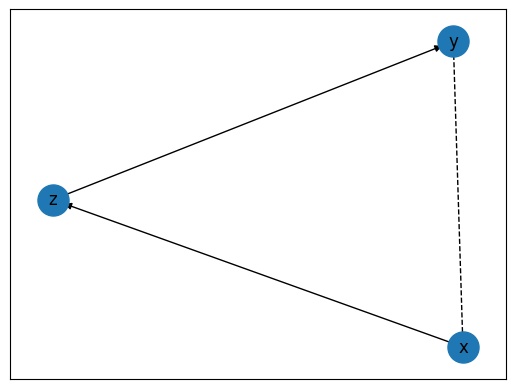

In [38]:
g.draw()

# Examples

In this section, I show how my code can be used to identify interventional distributions in two toy examples.

# Next Steps
- prove Whittemore broken (simplification, nonpositivity)
- randomly generated tests for correctness and benchmarking
- educational materials
- estimation code debug + quantization
- more compelling motivation
- end-to-end demo

# References

Bhattacharya, R., Nabi, R., & Shpitser, I. (2021). Semiparametric Inference For Causal Effects In Graphical Models With Hidden Variables (arXiv:2003.12659). arXiv. http://arxiv.org/abs/2003.12659


Breitling, L. P. (2010). dagR: A suite of R functions for directed acyclic graphs. Epidemiology (Cambridge, Mass.), 21(4), 586–587. https://doi.org/10.1097/EDE.0b013e3181e09112


Brulé, J. (2018). Whittemore: An embedded domain specific language for causal programming (arXiv:1812.11918). arXiv. https://doi.org/10.48550/arXiv.1812.11918


Efficiently Finding Conditional Instruments for Causal Inference. (n.d.). 7.
Identification With Surrogates—Ananke-causal documentation. (n.d.). Retrieved October 3, 2022, from https://ananke.readthedocs.io/en/latest/notebooks/identification_surrogates.html


Knüppel, S., & Stang, A. (2010). DAG program: Identifying minimal sufficient adjustment sets. Epidemiology (Cambridge, Mass.), 21(1), 159. https://doi.org/10.1097/EDE.0b013e3181c307ce


Leslie Myint (Director). (2020, September 13). Estimating Causal Effects: Inverse Probability Weighting. https://www.youtube.com/watch?v=PfLYPt9ur4g


Rice U ECE (Director). (2021, October 26). Prof. Ilya Shpitser | The Proximal ID Algorithm. https://www.youtube.com/watch?v=6nZslQafmYQ


Sharma, A., & Kiciman, E. (2020). DoWhy: An End-to-End Library for Causal Inference (arXiv:2011.04216). arXiv. https://doi.org/10.48550/arXiv.2011.04216


Shpitser, I. (2006). Identification of Joint Interventional Distributions in Recursive Semi-Markovian Causal Models. 8.


Shpitser, I. (2008). Complete Identi cation Methods for Causal Inference. 114.


Shpitser, I., & Pearl, J. (n.d.). Identiﬁcation of Conditional Interventional Distributions. 8.


Shpitser, I., Richardson, T. S., & Robins, J. M. (2012). An Efficient Algorithm for Computing Interventional Distributions in Latent Variable Causal Models (arXiv:1202.3763). arXiv. https://doi.org/10.48550/arXiv.1202.3763


Shpitser, I., & Sherman, E. (2018). Identification of Personalized Effects Associated With Causal Pathways. Uncertainty in Artificial Intelligence: Proceedings of the ... Conference. Conference on Uncertainty in Artificial Intelligence, 2018, 198.


Shpitser, I., VanderWeele, T., & Robins, J. M. (2012). On the Validity of Covariate Adjustment for Estimating Causal Effects (arXiv:1203.3515). arXiv. https://doi.org/10.48550/arXiv.1203.3515


Shpitser, I., Wood-Doughty, Z., & Tchetgen, E. J. T. (2021). The Proximal ID Algorithm (arXiv:2108.06818). arXiv. https://doi.org/10.48550/arXiv.2108.06818


Textor, J., & Liskiewicz, M. (n.d.). Adjustment Criteria in Causal Diagrams: An Algorithmic Perspective. 8.


Textor, J., van der Zander, B., Gilthorpe, M. S., Liśkiewicz, M., & Ellison, G. T. H. (2017). Robust causal inference using directed acyclic graphs: The R package ‘dagitty.’ International Journal of Epidemiology, dyw341. https://doi.org/10.1093/ije/dyw341


Tian, J., & Pearl, J. (n.d.). A General Identiﬁcation Condition for Causal Effects. 7.


Tikka, S., & Karvanen, J. (n.d.). Simplifying Probabilistic Expressions in Causal Inference. 30.
Van der Zander, B., & Liskiewicz, M. (2016). Separators and Adjustment Sets in Markov Equivalent DAGs. Proceedings of the AAAI Conference on Artificial Intelligence, 30(1). https://doi.org/10.1609/aaai.v30i1.10424


# Appendices

## Appendix 1: HC and LO Applications

### HC Applications

#induction

Structural causal modeling is all about principled approaches to induction. I carefully explain how inference is conceptualized within this framework, and I draw connections between the framework and predictions that result on actual datasets. I show a deep understanding of the nuances of inductive reasoning.


#algorithms


I explain the tradeoffs between a number of approaches to identification. I carefully explain how each alternative works, and I provide a high-level overview of Shpitser’s identification algorithm. I use asymptotic complexity to characterize tradeoffs. I implement Shpitser’s identification algorithm.


#variables

I carefully handle distinctions between treatment, outcome, and control variables. I provide a subtle discussion of the relationships between treatment and outcome variables in the structural causal modeling framework. I explain how treatment variables in a causal estimand may be converted to control variables or excluded via identification.


#probability

I show a deep understanding of probabilistic expressions and how they can be manipulated via the two rules of probability. I show how an extension to the basic logic of probability (do-expressions) can be incorporated into probabilistic reasoning.

#deduction

The do-calculus is a framework for using formal mathematics to reason about the very hairy and complex inductive problem of causal inference. I present the key intuitions behind the do-calculus, and then leverage an algorithm based on the do-calculus to perform identification. In addition, I make use of mathematical reasoning to prove a number of small supporting points.

#organization


Structural causal modeling is a complex framework for reasoning about inductive reasoning. I break down this highly complex and interconnected topic into a series of short digestible insights, each of which I present in a subsection. I present the idea in an order which allows the reader to build an intuition for the field.


#professionalism


For the final project, I will reformat this report using Latex.


#composition

I explain a complex, technically rigorous topic in a way that is accessible to someone educated in mathematics or computer science. I carefully handle jargon—using it only when necessary and being careful to define my terms. I condense most of the information I have learned over the course of a year-long literature review into 8 pages of background information. I balance concision with clarity in a highly difficult explanation.

#regression


I explain how regression modeling (under the name estimation) fits into the framework of structural causal modeling. I show a deep understanding of the role of regression in larger causal inference through my explanation of the role of abstract statistical estimators. For the final capstone, I will implement a regressions model to estimate causal effects, using abstract estimators derived from my implementation of identification.


#correlation


Rather than referring to correlation directly, I discuss the more general notion of statistical estimation. I explain how association in the joint distribution of a dataset relates to d-separation and live paths in the causal model. I explain how statistical association can change as a result of conditioning, and I present a complete account (based on Pearl’s work) of when this occurs.


#sampling


All of the difficulties of observational research fundamentally result from biased samples. In the final deliverable, I will explain how sampling bias in a real dataset can be controlled for using structural causal models.

#observationalstudy


I implement a complex software library aimed to help researchers working with observational data. I show a deep understanding of the pitfalls of observational research through my explanation of confounding and collider bias. I explain how identification can be used to remove biases from estimation of causal effects.


#modeling


I show a deeply researched and incredibly rigorous understanding of the structural causal modeling approach to causal inference. I explain how the “moving parts” of the model relate to changes in its predictions for the data. I implement a tool to aid in using structural causal modeling on real data.


#comparisongroups


In observational research, proper control groups are rarely available. The marginalization and control operations called for in the abstract estimator returned from identification can be interpreted as reweighting and excluding existing data in a way that synthetically generates a proper control group from available data. I will develop this analogy further in the final deliverable.


### LO Applications

#search


Deriving an abstract estimator using the do-calculus is fundamentally a search problem. I explain the workings of two approaches to solving this problem: adjustment set search, which relies on backtracking, and Shpitser’s identification algorithm, which can be interpreted as a dynamic programming solution. I will further develop these connections in the final deliverable.


#datamodel


I provide an explanation of structural causal modeling which demonstrates deep understanding. I provide extensive discussion of benefits and pitfalls. I implement a challenging subroutine of the structural causal modeling workflow. For the final deliverable, I will apply structural causal modeling (and my code) to a data analysis.


#quantprofessionalism


For the final deliverable, I will format this report using latex, following conventional guidelines for the reporting of figures. I will make my code available as a well-formatted and commented GitHub repository.


#numimplementation


For the final project, a stretch goal is to implement estimation. This is a classic numerical algorithm, where issues of convergence, numerical precision, and iterative solving will come into play.


### Capstone LO Applications

- #qualitydeliverables
- #curation
- #navigation
- #outcomeanalysis

## Appendix 2: Documentation

This appendix contains documentation which can be found on the project website. I present it here as work compelted towards the project

### Landing Page

![](2023-02-26-04-04-18.png)

### Quickstart Guide

![](2023-02-26-04-04-52.png)
![](2023-02-26-04-05-15.png)
![](2023-02-26-04-05-29.png)

### Expression Module Documentation

![](2023-02-26-04-06-16.png)

### Graph Module Documentation

![](2023-02-26-04-06-43.png)

### Variable Module Documentation

![](2023-02-26-04-07-22.png)

### Submodule Documentation

![](2023-02-26-04-07-57.png)
![](2023-02-26-04-08-12.png)
![](2023-02-26-04-08-27.png)
![](2023-02-26-04-08-47.png)
![](2023-02-26-04-09-02.png)
![](2023-02-26-04-09-16.png)
![](2023-02-26-04-09-29.png)

## Appendix 3: Code

### Estimation Code (In Progress)

This is experimental code that I wrote for use in estimation. It is still somewhat buggy, but it demonstrates the direction of the project.

In [1]:
from pqp.variable import make_vars, Variable
from pqp.graph import Graph
from pqp.expression import Expression, Marginal, P, Product, Quotient

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

x, y, z = make_vars("xyz")
g = Graph([
    z <= x,
    y <= z,
    x & y
])
estimand = g.idc([y], [x])
estimand.display()

<IPython.core.display.Math object>

In [2]:
I = object()
def p(*args):
    acc = vars = []
    given = []
    for arg in args:
        if arg is I:
            acc = given
        elif not isinstance(arg, Variable):
            raise ValueError("Expected Variable")
        else:
            acc.append(arg)
    return P(vars, given)

V = Variable

In [3]:
class attrdict(dict):
    def __getattr__(self, key):
        return self[key]

class CategoricalDistribution:
    def __init__(self, data, observed=None, prior=5):
        self.data = data
        self.n = data.shape[0]
        self.vars = attrdict({col: V(col) for col in data.columns})

        observed = observed or list(data.columns)
        domain = 1
        for obs in observed:
            domain *= len(np.unique(data[obs]))
        prior_observations = domain * prior

        self.chance_prior = prior_observations / (self.n + prior_observations)
        self.prior = self.chance_prior / domain
    
    def approx_p(self, expr: P, context):
        data = self.data
        for cond in expr.given:
            data = data[data[cond.name] == context[cond.name]]

        mask = np.ones(data.shape[0], dtype=bool)
        for var in expr.vars:
            if var.name not in context:
                raise ValueError(f"Missing context for {var.__repr__()}")
            mod = data[var.name] == context[var.name]
            mask = mask & mod
                
        return (mask.sum() / data.shape[0])*(1-self.chance_prior) + self.prior
    
    def approx_marginal(self, expr: Marginal, context):
        acc = 0
        if expr.sub:
            summation_var = expr.sub[0].name
            expr = expr.expr if len(expr.sub) == 1 else Marginal(expr.sub[1:], expr.expr)
            for val in np.unique(self.data[summation_var]):
                acc += self.approx(expr, {summation_var: val, **context})
        return acc
    
    def approx_product(self, expr: Product, context):
        acc = 1
        for e in expr.expr:
            acc *= self.approx(e, context)
        return acc
    
    def approx_quotient(self, expr: Quotient, context):
        return self.approx(expr.numer, context) / self.approx(expr.denom, context)

    def approx(self, expr, context = None):
        context = context or {}
        if isinstance(expr, P):
            res = self.approx_p(expr, context)
        elif isinstance(expr, Marginal):
            res = self.approx_marginal(expr, context)
        elif isinstance(expr, Product):
            res = self.approx_product(expr, context)
        elif isinstance(expr, Quotient):
            res = self.approx_quotient(expr, context)
        else:
            raise ValueError("Unsupported expression type: {}".format(type(expr)))
        return res

In [5]:
np.random.seed(137)
n = 10

severity = np.random.binomial(3, 0.5, size=n)
doctor_noise = np.random.binomial(1, 0.1, size=n)
print((severity > 1).astype(int))
print(doctor_noise)
treatment = ((severity > 1) != doctor_noise).astype(int)

# print(treatment)

pathway_predisposition = 0# np.random.binomial(2, 0.5, size=n)
pathway = pathway_predisposition - treatment

outcome_noise = 0#np.random.binomial(2, 0.5, size=n)
outcome = pathway + severity + outcome_noise

model_vars = {}
for name in ["severity", "treatment", "pathway", "outcome"]:
    model_vars[name] = Variable(name)

df = pd.DataFrame({
    "severity": severity,
    "treatment": treatment,
    "pathway": pathway,
    "outcome": outcome,
})

df.head(10)

[1 0 1 1 0 1 1 0 1 0]
[1 0 0 0 0 0 0 0 0 0]


,severity,treatment,pathway,outcome
0,3,0,0,3
1,0,0,0,0
2,2,1,-1,1
3,2,1,-1,1
4,1,0,0,1
5,2,1,-1,1
6,3,1,-1,2
7,0,0,0,0
8,2,1,-1,1
9,1,0,0,1


In [6]:
treat_outcome = df.outcome[df.treatment == 1].mean()
control_outcome = df.outcome[df.treatment == 0].mean()

print(f"treat outcome: {treat_outcome}")
print(f"control outcome: {control_outcome}")
print(f"treatment effect (naive): {treat_outcome - control_outcome}")

treat outcome: 1.2
control outcome: 1.0
treatment effect (naive): 0.19999999999999996


In [7]:
class Model:
    def __init__(self, dist, graph):
        self.dist = dist
        self.graph = graph
    
    def estimand(self, y, x=None, z=None):
        if x == None:
            x = []
        if z == None:
            z = []
        return self.graph.idc(y=[V(y)], x=[V(i) for i in x], z=[V(i) for i in z])
    
    def expectation(self, var, do=None, given=None):
        do = do or {}
        given = given or {}
        estimand = self.estimand(var, do.keys(), given.keys())

        acc = 0
        prob_acc = 0
        for val in np.unique(dist.data[var]):
            prob = self.dist.approx(estimand, {var: val, **do, **given})
            prob_acc += 1
            acc += prob * val
            print(prob, val)
        
        if abs(prob_acc - 1) > 1e-6:
            raise Exception(f"Probabilities do not sum to 1 (eps ~= {abs(prob_acc - 1)})")

        return acc

In [8]:
prior = 0.01

dist = CategoricalDistribution(df, observed=["treatment", "outcome", "pathway"], prior=prior)
graph = Graph([
    dist.vars.pathway <= dist.vars.treatment,
    dist.vars.outcome <= dist.vars.pathway,
    dist.vars.outcome & dist.vars.treatment,
])
model = Model(dist, graph)

print(dist.chance_prior)
model.estimand("outcome", ["treatment"]).display()

outcome_control = model.expectation("outcome", do={"treatment": 0})
outcome_treat = model.expectation("outcome", do={"treatment": 1})
print(f"treat outcome: {outcome_treat}")
print(f"control outcome: {outcome_control}")
print(f"treatment effect (my model): {outcome_treat - outcome_control}")

0.015748031496062992


<IPython.core.display.Math object>

0.39763779527559057 0
0.39763779527559057 1
0.003937007874015748 2
0.20078740157480315 3


Exception: Probabilities do not sum to 1 (eps ~= 3)

In [9]:
dist = CategoricalDistribution(df, observed=["treatment", "outcome", "pathway"], prior=prior)
graph = Graph([
    dist.vars.pathway <= dist.vars.treatment,
    dist.vars.outcome <= dist.vars.pathway,
    dist.vars.outcome & dist.vars.treatment,
])
model = Model(dist, graph)

print(dist.chance_prior)
model.estimand("outcome", ["treatment"]).display()

outcome_control = model.expectation("outcome", do={"treatment": 0})
outcome_treat = model.expectation("outcome", do={"treatment": 1})
print(f"treat outcome: {outcome_treat}")
print(f"control outcome: {outcome_control}")
print(f"treatment effect (my model): {outcome_treat - outcome_control}")

0.015748031496062992


<IPython.core.display.Math object>

0.39763779527559057 0
0.39763779527559057 1
0.003937007874015748 2
0.20078740157480315 3


Exception: Probabilities do not sum to 1 (eps ~= 3)

In [10]:
dist = CategoricalDistribution(df, prior=prior/4)
graph = Graph([
    # dist.vars.pathway <= dist.vars.treatment,
    # dist.vars.outcome <= dist.vars.pathway,
    dist.vars.outcome <= dist.vars.treatment,
    dist.vars.treatment <= dist.vars.severity,
    dist.vars.outcome <= dist.vars.severity,
])
model = Model(dist, graph)

print(dist.chance_prior)
model.estimand("outcome", ["treatment"]).display()

outcome_control = model.expectation("outcome", do={"treatment": 0})
outcome_treat = model.expectation("outcome", do={"treatment": 1})
print(f"treat outcome: {outcome_treat}")
print(f"control outcome: {outcome_control}")
print(f"treatment effect (god): {outcome_treat - outcome_control}")

0.015748031496062992


<IPython.core.display.Math object>

0.5917808824395704 0
0.5917808824395704 1
0.394930488738783 2
0.5915354330708662 3


Exception: Probabilities do not sum to 1 (eps ~= 3)

### Python Library

This is the code from the Python library. It has the following structure.

- `pqp`
    - `__init__.py`
    - `expression.py`
    - `graph.py`
    - `utils.py`
    - `variable.py`
    - `tests`
        - `test_pqp.py`
        - `test_variable.py`

In [ ]:
# __init__.py

import pqp.graph
import pqp.expression
import pqp.variable
import pqp.utils

In [ ]:
# expression.py

import json

def parse_json(exp):
    """Parses JSON returned from backend.id() into an Expression object.

    Args:
        exp (str or dict): The JSON string or parsed JSON object.
    
    Returns:
        Expression: The parsed expression.
    """
    from pqp.variable import Variable

    if isinstance(exp, str):
        return parse_json(json.loads(exp))

    if exp["type"] == "Quotient":
        return Quotient(
            parse_json(exp["numer"]),
            parse_json(exp["denom"]),
        )
    elif exp["type"] == "Product":
        return Product(
            [parse_json(e) for e in exp["exprs"]],
        )
    elif exp["type"] == "Marginal":
        return Marginal(
            [Variable(x) for x in exp["sub"]],
            parse_json(exp["exp"]),
        )
    elif exp["type"] == "Hedge":
        return Hedge()
    elif exp["type"] == "P":
        return P(
            [Variable(e) for e in exp["vars"]],
            [Variable(e) for e in exp["given"]],
        )
    else:
        raise Exception("Unknown expression type: " + exp["type"])

class Expression:
    """Base class for all expressions.
    
    The primary use of Expression is to represent the results of identification. However,
    Expressions can be constructed from Variables and other Expressions. Using the
    infix `/` and `*` operators.

    Examples:
        >>> from pqp.variable import make_vars
        >>> x, y = make_vars("xy")
        >>> x / y
        Quotient(Variable(x), Variable(y))
        >>> x * y
        Product([Variable(x), Variable(y)])
    
    Expressions can be represented in a number of different ways.
        - `__repr__` returns an unambiguous representation of the expression
        - `__str__` returns a human-readable (ascii, symbolic) representation
        - `to_latex` returns a Latex representation of the expression
    
    """

    def display(self):
        """Renders an expression as Latex using IPython.display"""
        from IPython.display import display, Math
        return display(Math(self.to_latex()))
    
    def syntactic_eq(self, other):
        """Test whether two Expressions are syntactically identical (structural compare without sorting first)"""
        raise NotImplementedError()
    
    def sorted(self):
        """Returns a sorted copy of an expression for structural comparison."""
        raise NotImplementedError()
    
    def __eq__(self, other):
        """Returns True if two expressions are structurally equivalent."""
        if not isinstance(other, Expression):
            return False
        return self.sorted().syntactic_eq(other.sorted())
    
    def to_latex(self):
        """Returns the Latex representation of an expression."""
        raise NotImplementedError()
    
    def __truediv__(self, other):
        """Returns a Quotient of the expressions."""
        if isinstance(other, Expression):
            return Quotient(self, other)
        else:
            raise TypeError("Cannot divide by non-expression")
    
    def __mul__(self, other):
        """Returns a Product of the expressions."""
        if isinstance(other, Expression):
            return Product([self, other])
        else:
            raise TypeError("Cannot multiply by non-expression")

class Quotient(Expression):
    """Represents a quotient of expressions

    Args:
        numer (Expression): The numerator
        denom (Expression): The denominator
    """
    def __init__(self, numer, denom):
        if not isinstance(numer, Expression):
            raise TypeError("numerator must be an Expression")
        if not isinstance(denom, Expression):
            raise TypeError("denominator must be an Expression")
        
        self.numer = numer
        self.denom = denom
    
    def syntactic_eq(self, other):
        return (
            isinstance(other, Quotient) and
            self.numer == other.numer and
            self.denom == other.denom
        )
    
    def sorted(self):
        return Quotient(self.numer.sorted(), self.denom.sorted())
    
    def __repr__(self):
        return f"Quotient({repr(self.numer)}, {repr(self.denom)})"
    
    def __str__(self):
        return "[%s / %s]" % (str(self.numer), str(self.denom))
    
    def to_latex(self):
        return "{" + self.numer.to_latex() + " \\over " + self.denom.to_latex() + "}"

class Product(Expression):
    """Represents a product of expressions

    Args:
        expr (list of Expression): The expressions to multiply
    """
    def __init__(self, expr):
        if not isinstance(expr, list):
            expr = list(expr)
        for e in expr:
            if not isinstance(e, Expression):
                raise TypeError("Product must be a list of Expressions")
        
        self.expr = expr
    
    def syntactic_eq(self, other):
        return (
            isinstance(other, Product) and
            self.expr == other.expr
        )
    
    def sorted(self):
        return Product(sorted([e.sorted() for e in self.expr], key=str))
    
    def __repr__(self):
        return f"Product({[repr(e) for e in self.expr]})"
    
    def __str__(self):
        return " * ".join([str(e) for e in self.expr])
    
    def to_latex(self):
        return " ".join([e.to_latex() for e in self.expr])

class Marginal(Expression):
    """Represents a sum

    Args:
        sub (list of Variable): The variables to sum over
        expr (Expression): The expression to sum
    """
    def __init__(self, sub, expr):
        from pqp.variable import Variable

        if not isinstance(expr, Expression):
            raise TypeError("Marginal must be a list of Expressions")
        if isinstance(sub, Variable):
            sub = [sub]
        elif not isinstance(sub, list):
            sub = list(sub)
        for s in sub:
            if not isinstance(s, Variable):
                raise TypeError("Marginal must be a list of Variables")

        self.sub = sub
        self.expr = expr
    
    def sorted(self):
        return Marginal(sorted(self.sub), self.expr.sorted())
    
    def syntactic_eq(self, other):
        return (
            isinstance(other, Marginal) and
            self.sub == other.sub and
            self.expr == other.expr
        )
    
    def __repr__(self):
        return f"Marginal({self.sub}, {repr(self.expr)})"
    
    def __str__(self):
        return "Σ_(%s) [ %s ]" % (", ".join(str(c) for c in self.sub), str(self.expr))
    
    def to_latex(self):
        return (
            "\\sum_{" + ", ".join(c.to_latex() for c in self.sub) + "} \\big(" +
            self.expr.to_latex()
            + "\\big)")

class P(Expression):
    """Expression representing a probability or conditional probability

    Args:
        vars (list of Variable): probability variables
        given (list of Variable): conditioned variables
    """
    def __init__(self, vars, given=None):
        from pqp.variable import Variable

        if not isinstance(vars, list):
            vars = list(vars)
        for v in vars:
            if not isinstance(v, Variable):
                raise TypeError("vars must be a list of Variables")
        
        if given is not None:
            if not isinstance(given, list):
                given = list(given)
            for g in given:
                if not isinstance(g, Variable):
                    raise TypeError("given must be a list of Variables")
        
        self.vars = vars
        self.given = given or []
    
    def sorted(self):
        return P(
            sorted(self.vars, key=lambda v: v.name),
            sorted(self.given, key=lambda v: v.name)
            )
    
    def __str__(self):
        v = ", ".join(str(c) for c in self.vars)
        g = ", ".join(str(c) for c in self.given)
        if not v:
            return "1"
        return "P(" + v + (f"| {g}" if g else "") + ")"
    
    def syntactic_eq(self, other):
        return (
            isinstance(other, P) and
            self.vars == other.vars and
            self.given == other.given
        )
    
    def __repr__(self):
        if self.given:
            return f"P({self.vars} | {self.given})"
        else:
            return f"P({self.vars})"
    
    def to_latex(self):
        v = ", ".join(c.to_latex() for c in self.vars)
        g = ", ".join(c.to_latex() for c in self.given)
        if not v:
            return "1"
        return "P(" + v + (f" \\mid {g}" if g else "") + ")"

class Hedge(Expression):
    """Represents a failure to identify the query"""
    def syntactic_eq(self, other):
        return isinstance(other, Hedge)
    
    def sorted(self):
        return self
    
    def __str__(self):
        return "FAIL"
    
    def to_latex(self):
        return "\\textbf{FAIL}"

In [ ]:
# graph.py

from pqp.expression import parse_json
from pqp.variable import Variable
from pqp.pqp import id
import json

class Graph:
    """A causal graph
    
    Example:
        >>> x = Variable("X")
        >>> y = Variable("Y")
        >>> g = Graph([
        ...     y <= x,
        ... ])
        >>> g.idc([y], [x])
        P(y | x)
    
    Args:
        edges (list of DirectedEdge or BidirectedEdge): the edges in the graph
    """
    def __init__(self, edges=[]):
        self.bi_edges = []
        self.directed_edges = []
        self.add_edges(edges)
    
    def add_edges(self, edges):
        while edges:
            edge = edges.pop()
            if isinstance(edge, BidirectedEdge) or isinstance(edge, DirectedEdge):
                self.add_edge(edge)
            elif isinstance(edge, list):
                edges.extend(edge)
            else:
                raise TypeError(f"Cannot add edge of type {type(edge)}")
    
    def add_edge(self, edge):
        """Adds an edge to the graph
        
        Args:
            edge (DirectedEdge or BidirectedEdge): the edge to add
        """
        if isinstance(edge, BidirectedEdge):
            self.bi_edges.append(edge)
        elif isinstance(edge, DirectedEdge):
            self.directed_edges.append(edge)
        else:
            raise TypeError(f"Cannot add edge of type {type(edge)}")
    
    def bi_edge_tuples(self):
        return [(str(edge.a), str(edge.b)) for edge in self.bi_edges]
    
    def di_edge_tuples(self):
        return [(str(edge.start), str(edge.end)) for edge in self.directed_edges]
    
    def idc(self, y, x, z=[]):
        """Identification of conditional interventional distribution.

        Args:
            x (list of Variable): intervention variables
            y (list of Variable): outcome variables
            z (list of Variable): conditioning variables (optional)
        
        Returns:
            Expression: the expression for the interventional distribution
        """
        # from pqp.pqp import id
        res = id(
            self.di_edge_tuples(),
            self.bi_edge_tuples(),
            [str(v) for v in x],
            [str(v) for v in y],
            [str(v) for v in z],
        )
        return parse_json(json.loads(res))
    
    def draw(self):
        """Draws the causal diagram using networkx"""
        import networkx as nx

        layout_graph = nx.Graph()
        layout_graph.add_edges_from(self.bi_edge_tuples() + self.di_edge_tuples())
        layout = nx.spring_layout(layout_graph, scale=1, k=1/len(layout_graph.nodes)**0.5)
        nx.draw_networkx_nodes(layout_graph, layout, node_size=500)

        digraph = nx.DiGraph()
        digraph.add_edges_from(self.di_edge_tuples())
        nx.draw_networkx_edges(digraph, layout)

        bigraph = nx.Graph()
        bigraph.add_edges_from(self.bi_edge_tuples())
        nx.draw_networkx_edges(bigraph, layout, style="dashed")

        nx.draw_networkx_labels(layout_graph, layout)
    
    def __repr__(self):
        return f"Graph({self.bi_edges + self.directed_edges})"
    
    def __str__(self):
        return f"<Graph n_edges={len(self.bi_edges + self.directed_edges)}>"

class DirectedEdge:
    """A directed edge between two variables, represents a causal relationship
    
    Args:
        start (Variable): the start of the edge
        end (Variable): the end of the edge
    """
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def __repr__(self):
        return f"DirectedEdge(start={self.start}, end={self.end})"
    
    def __str__(self):
        return f"{self.end} <= {self.start}"
    
    def __eq__(self, other):
        return (isinstance(other, DirectedEdge) and
                self.start == other.start and
                self.end == other.end)
    
    def __le__(self, other):
        if isinstance(other, Variable):
            return [self, self.start <= other]
        elif isinstance(other, DirectedEdge):
            return [self, self.start <= other.end, other]
        elif isinstance(other, BidirectedEdge):
            return [self, self.start <= other.a, other]
        elif isinstance(other, list):
            return [self] + [self <= o for o in other]
        else:
            raise TypeError(f"Cannot add edge of type {type(other)}")

class BidirectedEdge:
    """A bidirected edge between two variables, represents confounding in the causal model
    
    Args:
        a (Variable): one of the variables
        b (Variable): the other variable
    """
    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    def __repr__(self):
        return f"BidirectedEdge({self.a}, {self.b})"
    
    def __str__(self):
        return f"{self.a} & {self.b}"
    
    def __eq__(self, other):
        return isinstance(other, BidirectedEdge) and (
            (self.a == other.a and self.b == other.b) or
            (self.a == other.b and self.b == other.a)
        )

    def __le__(self, other):
        if isinstance(other, Variable):
            return [self, self.b & other]
        elif isinstance(other, DirectedEdge):
            return [self, self.b & other.end, other]
        elif isinstance(other, BidirectedEdge):
            return [self, self.b & other.a, other]
        elif isinstance(other, list):
            return [self] + [self & o for o in other]
        else:
            raise TypeError(f"Cannot add edge of type {type(other)}")

In [ ]:
# utils.py

def recursive_sort(d):
    if isinstance(d, dict):
        return {k: recursive_sort(v) for k, v in sorted(d.items())}
    elif isinstance(d, list):
        return list(sorted(recursive_sort(v) for v in d))
    elif isinstance(d, tuple):
        return tuple(sorted(recursive_sort(v) for v in d))
    else:
        return d

In [ ]:
# variable.py

from pqp.expression import Expression

class Variable(Expression):
    """A variable in the causal model
    
    Dunder methods allow for convenient syntax for creating causal graphs.

    Example:
        >>> x = Variable("x")
        >>> y = Variable("y")
        >>> x <= y
        DirectedEdge(Variable("x"), Variable("y"))
        >>> x & y
        BidirectedEdge(Variable("x"), Variable("y"))
    
    Args:
        name (str): the name of the variable
    """
    def __init__(self, name):
        self.name = name
    
    def __repr__(self):
        return f"Variable({self.name})"
    
    def __eq__(self, other):
        return isinstance(other, Variable) and self.name == other.name
    
    def __str__(self):
        return self.name
    
    def __le__(self, other):
        from pqp.graph import DirectedEdge, BidirectedEdge
        if isinstance(other, Variable):
            return DirectedEdge(other, self)
        elif isinstance(other, DirectedEdge):
            return self <= other.end
        elif isinstance(other, BidirectedEdge):
            return self <= other.a
        elif isinstance(other, list):
            return [self <= v for v in other]
        else:
            raise TypeError(f"Cannot compare {type(self)} with {type(other)}")
    
    def __and__(self, other):
        from pqp.graph import BidirectedEdge, DirectedEdge
        if isinstance(other, Variable):
            return BidirectedEdge(self, other)
        elif isinstance(other, BidirectedEdge):
            return self & other.a
        elif isinstance(other, DirectedEdge):
            return self & other.end
        elif isinstance(other, list):
            return [self & v for v in other]
        else:
            raise TypeError(f"Cannot compare {type(self)} with {type(other)}")
    
    def to_latex(self):
        return self.name

def make_vars(names):
    """Creates a list of variables from a list of names
    
    Example:
        >>> make_vars(["x", "y", "z"])
        [Variable("x"), Variable("y"), Variable("z")]
        >>> x, y, z = make_vars("xyz")
        [Variable("x"), Variable("y"), Variable("z")]
    
    """
    return [Variable(name) for name in names]

### Rust Library

This is the underlying Rust library code. The Rust library is significantly larger than the Python library as it implements the main functionality. It has the following layout:

- `src`
    - `api`
        - `mod.rs`
        - `functions.rs`
        - `python.rs`
        - `wrapper.rs`
        - `test.rs`
    - `form`
        - `mod.rs`
        - `form.rs`
        - `simplify.rs`
        - `tikka.rs`
        - `test_form.rs`
        - `test_simplify.rs`
    - `graph`
        - `mod.rs`
        - `graph.rs`
        - `bigraph.rs`
        - `digraph.rs`
        - `graph_builder.`rs
        - `node.rs`
        - `tests.rs`
    - `identification`
        - `mod.rs`
        - `shpitser.rs`
        - `tests.rs`
    - `model`
        - `mod.rs`
        - `examples.rs`
        - `model.rs`
        - `order.rs`
        - `tests.rs`
    - `utils`
        - `mod.rs`
        - `defaults.rs`
        - `set_utils.rs`
        - `utils.rs`
        - `tests.rs`
    - `lib.rs`
    - `test.rs`

```rust
// mod.rs

pub mod wrapper;
mod functions;
mod test;

pub mod python;
```

```rust
// functions.rs

from pqp.expression import Expression

class Variable(Expression):
    """A variable in the causal model
    
    Dunder methods allow for convenient syntax for creating causal graphs.

    Example:
        >>> x = Variable("x")
        >>> y = Variable("y")
        >>> x <= y
        DirectedEdge(Variable("x"), Variable("y"))
        >>> x & y
        BidirectedEdge(Variable("x"), Variable("y"))
    
    Args:
        name (str): the name of the variable
    """
    def __init__(self, name):
        self.name = name
    
    def __repr__(self):
        return f"Variable({self.name})"
    
    def __eq__(self, other):
        return isinstance(other, Variable) and self.name == other.name
    
    def __str__(self):
        return self.name
    
    def __le__(self, other):
        from pqp.graph import DirectedEdge, BidirectedEdge
        if isinstance(other, Variable):
            return DirectedEdge(other, self)
        elif isinstance(other, DirectedEdge):
            return self <= other.end
        elif isinstance(other, BidirectedEdge):
            return self <= other.a
        elif isinstance(other, list):
            return [self <= v for v in other]
        else:
            raise TypeError(f"Cannot compare {type(self)} with {type(other)}")
    
    def __and__(self, other):
        from pqp.graph import BidirectedEdge, DirectedEdge
        if isinstance(other, Variable):
            return BidirectedEdge(self, other)
        elif isinstance(other, BidirectedEdge):
            return self & other.a
        elif isinstance(other, DirectedEdge):
            return self & other.end
        elif isinstance(other, list):
            return [self & v for v in other]
        else:
            raise TypeError(f"Cannot compare {type(self)} with {type(other)}")
    
    def to_latex(self):
        return self.name

def make_vars(names):
    """Creates a list of variables from a list of names
    
    Example:
        >>> make_vars(["x", "y", "z"])
        [Variable("x"), Variable("y"), Variable("z")]
        >>> x, y, z = make_vars("xyz")
        [Variable("x"), Variable("y"), Variable("z")]
    
    """
    return [Variable(name) for name in names]
```

```rust
// python.rs
use pyo3::prelude::*;
use rand::Rng;
use std::cmp::Ordering;
use std::io;

use super::functions;
use super::wrapper::IDResult;

#[pyfunction]
fn hello_world () {
    println! ( "Hello, world!" );
}

#[pyfunction]
fn id (d_edges: Vec<(String, String)>, b_edges: Vec<(String, String)>, y: Vec<String>, x: Vec<String>, z: Vec<String>) -> PyResult<String> {
    
    let result = functions::id(d_edges, b_edges, x, y, z).estimand_json.replace("\\", "");
    Ok(result)
}

#[pymodule]
pub fn pqp(_py: Python, m: &PyModule) -> PyResult<()> {
    m.add_function(wrap_pyfunction!(hello_world, m)?)?;
    m.add_function(wrap_pyfunction!(id, m)?)?;
    Ok(())
}
```

```rust
// test.rs

#![cfg(test)]

use super::{
    wrapper::{FormWrapper, ModelWrapper},
    functions::id,
};
use crate::{
    utils::defaults::{set, Set},
};

#[test]
fn test_wrapper_bowgraph() {
    let mut m = ModelWrapper::new();
    m.add_effect("x", "y");
    m.add_confounding("x", "y");
    let res = m.id(set!["y".to_string()], set!["x".to_string()], set![]);
    assert_eq!(res.estimand_json, FormWrapper::Hedge.to_json());
}

#[test]
fn test_wrapper_fd() {
    let mut m = ModelWrapper::new();
    m.add_effect("x", "z");
    m.add_effect("z", "y");
    m.add_confounding("x", "y");
    let res = m.id(set!["y".to_string()], set!["x".to_string()], set![]);
    assert_ne!(res.estimand_json, FormWrapper::Hedge.to_json());
}

#[test]
fn test_wrapped_bd () {
    let mut m = ModelWrapper::new();
    m.add_effect("x", "y");
    m.add_effect("z", "y");
    m.add_effect("z", "x");

    let res = m.id(set!["y".to_string()], set!["x".to_string()], set!["z".to_string()]);
    assert_ne!(res.estimand_json, FormWrapper::Hedge.to_json());
}

#[test]
fn test_fn_id_fd () {
    let res = id(
        vec![("x".to_string(), "z".to_string()), ("z".to_string(), "y".to_string())],
        vec![("x".to_string(), "y".to_string())],
        vec!["y".to_string()],
        vec!["x".to_string()],
        vec![],
    );
    assert_ne!(res.estimand_json, FormWrapper::Hedge.to_json());
}
```

```rust
// wrapper.rs

use itertools::Itertools;

use crate::{
    model::{Model, ModelBuilder},
    utils::defaults::{set, Set, Map},
    graph::Node,
    form::{Form, form::AbstractForm},
};

pub struct ModelWrapper {
    model_builder: ModelBuilder,
    vars: Map<String, Node>,
}

pub type FormWrapper = AbstractForm<String>;

impl FormWrapper {
    pub fn to_json(&self) -> String {
        match self {
            FormWrapper::Marginal(sub, exp) => {
                format!(
                    "{{\"type\": \"Marginal\", \"sub\": [{:?}], \"exp\": {}}}",
                    sub.iter().format_default(", ").to_string(),
                    exp.to_json()
                )
            },
            FormWrapper::Quotient(numer, denom) => {
                format!(
                    "{{\"type\": \"Quotient\", \"numer\": {}, \"denom\": {}}}",
                    numer.to_json(),
                    denom.to_json()
                )
            },
            FormWrapper::P(vars, given) => {
                format!(
                    "{{\"type\": \"P\", \"vars\": [{:?}], \"given\": [{:?}]}}",
                    vars.iter().format_default(", "),
                    given.iter().format_default(", ")
                )
            },
            FormWrapper::Product(exprs) => {
                format!(
                    "{{\"type\": \"Product\", \"exprs\": [{}]}}",
                    exprs.iter().map(|e| {e.to_json()}).format_default(", ")
                )
            },
            FormWrapper::Hedge => "{\"type\": \"Hedge\"}".to_string(),
        }.replace("\\", "")
    }
}

impl ModelWrapper {
    pub fn new() -> ModelWrapper {
        ModelWrapper {
            model_builder: ModelBuilder::new(),
            vars: Map::new(),
        }
    }

    fn get_or_add_var(&mut self, name: &str) -> Node {
        if self.vars.contains_key(name) {
            return self.vars[name];
        } else {
            let var = self.vars.len() as i32;
            self.vars.insert(name.to_string(), var);
            self.model_builder.add_node(var);
            return var;
        }
    }

    pub fn form_sub(&self, form: Form) -> FormWrapper {
        let reversed: Map<i32, String> = self.vars.iter()
            .map(|(k, v)| (*v, k.clone()))
            .collect();

        fn substitute(f: &Form, reversed: &Map<i32, String>) -> FormWrapper {
            match f {
                Form::Marginal(sub, exp) => {
                    let sub: Set<String> = sub.iter().map(|s| reversed[s].to_owned()).collect();
                    let exp = substitute(exp, reversed);
                    FormWrapper::Marginal(sub, Box::new(exp))
                },
                Form::Quotient(numer, denom) => {
                    let numer = substitute(numer, reversed);
                    let denom = substitute(denom, reversed);
                    FormWrapper::Quotient(Box::new(numer), Box::new(denom))
                },
                Form::P(vars, given) => {
                    let vars = vars.iter().map(|s| reversed[s].to_owned()).collect();
                    let given = given.iter().map(|s| reversed[s].to_owned()).collect();
                    FormWrapper::P(vars, given)
                },
                Form::Product(exprs) => {
                    let exprs = exprs.iter().map(
                        |e| substitute(e, reversed)
                    ).collect();
                    FormWrapper::Product(exprs)
                },
                Form::Hedge => FormWrapper::Hedge,
            }
        }

        return substitute(&form, &reversed);
    }

    pub fn add_effect(&mut self, cause: &str, effect: &str) {
        let cause_n = self.get_or_add_var(cause);
        let effect_n = self.get_or_add_var(effect);
        // TODO: this seems backwards (!!??) but it works
        self.model_builder.add_directed_edge(effect_n, cause_n);
    }

    pub fn add_confounding(&mut self, cause: &str, effect: &str) {
        let cause_n = self.get_or_add_var(cause);
        let effect_n = self.get_or_add_var(effect);
        self.model_builder.add_confounded_edge(cause_n, effect_n);
    }

    pub fn id(&self, y: Set<String>, x: Set<String>, z: Set<String>) -> IDResult {

        let retrieve = |s: &String| {
            if self.vars.contains_key(s) {
                self.vars[s]
            } else {
                panic!("Variable {} not found", s);
            }
        };

        let y_n: Set<Node> = y.iter().map(retrieve).collect();
        let x_n: Set<Node> = x.iter().map(retrieve).collect();
        let z_n: Set<Node> = z.iter().map(retrieve).collect();

        let model = ModelBuilder::to_model(Box::new(self.model_builder.to_owned())).cond(&z_n);
        let p = model.id(&y_n, &x_n);

        // string formatting of query
        let mut query = "P(".to_string();
        if !y.is_empty() {
            for each in y { query += &format!("{}, ", each); }
            query += "| ";
            for each in x { query += &format!("{}, ", each); }
            for each in z { query += &format!("do({}), ", each); }
            query.pop();
            query.pop();
            query += ")"
        }

        return IDResult {
            estimand_json: self.form_sub(p).to_json(),
            query_string: query,
        };
    }
}

#[derive(Debug)]
pub struct IDResult {
    pub estimand_json: String,
    pub query_string: String,
}
```

```rust
// form.rs
use core::num;
use cute::c;

use crate::{
    utils::{
        set_utils::{difference, union, make_set},
        defaults::Set,
    },
    graph::Node
};

use super::simplify;

pub static HEDGE: Form = Form::Hedge;

#[derive(Debug, Clone, PartialEq, Eq)]
pub enum AbstractForm<T: Eq + std::hash::Hash> {
    Marginal(Set<T>, Box<AbstractForm<T>>),
    Product(Vec<AbstractForm<T>>),
    Quotient(Box<AbstractForm<T>>, Box<AbstractForm<T>>),
    P(Vec<T>, Vec<T>),
    Hedge
}

pub type Form = AbstractForm<Node>;

impl Form {
    pub fn marginal(over: Set<Node>, exp: Form) -> Form {
        Form::Marginal(over, Box::new(exp))
    }

    pub fn product(forms: Vec<Form>) -> Form {
        Form::Product(forms)
    }

    pub fn quotient(num: Form, denom: Form) -> Form {
        Form::Quotient(Box::new(num), Box::new(denom))
    }

    pub fn prob(vars: Vec<Node>) -> Form {
        Form::P(vars, vec![])
    }

    pub fn cond_prob(vars: Vec<Node>, given: Vec<Node>) -> Form {
        Form::P(vars, given)
    }

    pub fn free<'b>(form: &'b Form) -> Set<Node> {
        match form {
            Form::Marginal(sub, exp) => 
                difference(&Form::free(&**exp), &sub),
            Form::Quotient(numer, denom) =>
                union(&Form::free(&**numer), &Form::free(&**denom)),
            Form::P(vars, given) => {
                let mut set = Set::new();
                vars.iter().for_each(|e| {set.insert(*e);});
                given.iter().for_each(|e| {set.insert(*e);});
                return set;
            },
            Form::Product(exprs) => {
                let mut set = Set::new();
                for expr in exprs.iter() {
                    set.extend(Form::free(expr));
                }
                return set;
            },
            Form::Hedge => Set::new(),
        }
    }

    /// Finds P(subset | pred(subset)) in terms of p, where pred(x) is the
    /// predecessors of x in order.
    pub fn factorize_subset(order: Vec<Node>, p: Form, subset: &Set<Node>) -> Form {
        let mut free = Form::free(&p);
        let mut terms = Vec::new();

        for nxt in order.iter().enumerate() {
            let (i, v_i) = nxt;
            if subset.contains(v_i) {
                let v: Set<Node> = [*v_i].into_iter().collect();
                let pred = make_set((&order[i..]).iter().map(|e| *e));
                let unbound = difference(&free, &union(&pred, &v));
                let term = Form::quotient(
                    Form::marginal(unbound.clone(), p.clone()),
                    Form::marginal(union(&unbound, &v), p.clone())
                );
                terms.push(term);
            }
        }
        
        return Form::product(terms);
    }

    /// Factorize a form with respect to a given order
    pub fn factorize(order: Vec<Node>, p: Form) -> Form {
        let subset = make_set(order.iter().map(|e| *e));
        Form::factorize_subset(order, p, &subset)
    }

    /// determine if a form contains a hedge
    pub fn contains_hedge(&self) -> bool {
        match self {
            Form::Marginal(_, exp) => exp.contains_hedge(),
            Form::Product(exprs) => {
                for expr in exprs {
                    if expr.contains_hedge() {
                        return true;
                    }
                }
                return false;
            },
            Form::Quotient(numer, denom) => {
                numer.contains_hedge() || denom.contains_hedge()
            },
            Form::P(_, _) => false,
            Form::Hedge => true,
        }
    }

    pub fn form_type(form: &Self) -> i8 {
        match form {
            Form::Marginal(_, _) => 0,
            Form::Product(_) => 1,
            Form::Quotient(_, _) => 2,
            Form::P(_, _) => 3,
            Form::Hedge => 4,
        }
    }

    fn do_cmp(&self, other: &Self) -> Option<std::cmp::Ordering> {
        let s_val = Form::form_type(self);
        let o_val = Form::form_type(other);

        if s_val < o_val {
            return Some(std::cmp::Ordering::Less);
        } else if s_val > o_val {
            return Some(std::cmp::Ordering::Greater);
        }

        match (self, other) {
            (Form::Marginal(s_over, s_exp), Form::Marginal(o_over, o_exp)) => {
                if s_over.len() == o_over.len() {
                    s_exp.partial_cmp(o_exp)
                } else {
                    s_over.len().partial_cmp(&o_over.len())
                }
            },
            (Form::Product(s_exprs), Form::Product(o_exprs)) => {
                s_exprs.partial_cmp(o_exprs)
            },
            (Form::Quotient(s_numer, s_denom), Form::Quotient(o_numer, o_denom)) => {
                if s_numer == o_numer {
                    s_denom.partial_cmp(o_denom)
                } else {
                    s_numer.partial_cmp(o_numer)
                }
            },
            (Form::P(s_vars, s_given), Form::P(o_vars, o_given)) => {
                if s_vars == o_vars {
                    s_given.partial_cmp(o_given)
                } else {
                    s_vars.partial_cmp(o_vars)
                }
            },
            _ => Some(std::cmp::Ordering::Equal),
        }
    }

    /// applies form_map with the same func to child expressions, then applies func to self
    pub fn map (&self, func: fn(&Form) -> Form) -> Form {
        let mapped = match self {
            Form::Marginal(over, exp)
                => Form::marginal(over.clone(), exp.map(func)),
            Form::Product(exprs)
                => Form::product(exprs.iter().map(|e| e.map(func)).collect()),
            Form::Quotient(numer, denom)
                => Form::quotient(numer.map(func), denom.map(func)),
            _ => self.to_owned(),
        };
        return func(&mapped);
    }

    /// recursively sorts expressions, returning a new form
    pub fn sorted(&self) -> Form {
        match self {
            Form::Marginal(over, exp) => {
                Form::marginal(over.to_owned(), exp.sorted())
            },
            Form::Product(exprs) => {
                let mut exprs: Vec<Form> = exprs
                    .iter()
                    .map(|e| e.sorted())
                    .collect();
                exprs.sort();
                Form::product(exprs)
            },
            Form::Quotient(numer, denom) => {
                Form::quotient(numer.sorted(), denom.sorted())
            },
            Form::P(vars, cond) => {
                let mut vars = vars.to_owned();
                let mut cond = cond.to_owned();
                vars.sort();
                cond.sort();
                Form::cond_prob(vars, cond)
            }
            _ => self.to_owned(),
        }
    }

    pub fn cond_expand(&self) -> Form {
        self.map(|f| {
            match f {
                Form::P(vars, cond) => {
                    Form::quotient(
                        Form::prob(
                            vars.iter().cloned().chain(cond.iter().cloned()).collect()
                        ),
                        Form::prob(cond.to_owned())
                    )
                },
                _ => f.to_owned(),
            }
        })
    }

    pub fn structural_eq(&self, other: &Form) -> bool {
        self.sorted() == other.sorted()
    }

    /// Sorts and simplifies a form. Suitable for structural equality checks.
    pub fn simplify(&self) -> Form {
        simplify(&self.sorted())
    }
}

impl PartialOrd for Form {
    fn partial_cmp(&self, other: &Self) -> Option<std::cmp::Ordering> {
        Some(Form::cmp(&self, other))
    }
}

impl Ord for Form {
    fn cmp(&self, other: &Self) -> std::cmp::Ordering {
        Form::do_cmp(&self, other).unwrap()
    }   
}

pub fn one () -> Form {
    Form::prob(vec![])
}

```

```rust
// mod.rs

pub mod form;
pub use form::{Form, one, HEDGE};
mod simplify;
use simplify::simplify;

// tests
mod test_simplify;
mod test_form;
```

```rust
// simplify.rs


use core::num;
use std::{
    iter::Product,
    convert::identity,
};

use crate::{
    utils::{
        set_utils::{difference, make_set, union},
        defaults::Set,
        remove_duplicates_sorted,
    },
    graph::Node
};

use super::form::{Form, one, HEDGE};

pub fn promote_hedge(f: &Form) -> &Form {
    if f.contains_hedge() {
        &HEDGE
    } else {
        f
    }
}

/// Simplify a marginal expression.
/// Will reduce terms in a joint probability if it finds one.
pub fn simplify_marginal(f: &Form) -> Form {
    if let Form::Marginal(over, exp) = f {
        let exp_content = *exp.to_owned();

        if over.is_empty() {
            return exp_content;
        } else if let Form::Marginal(over2, exp2) = exp_content {
            return Form::marginal(union(&over, &over2), *exp2);
        } else if let Form::P(vars, cond) = exp_content {
            let vars_set: Set<Node> = vars.iter().cloned().collect();
            let new_over = difference(&over, &vars_set);
            let new_vars = difference(&vars_set, &over);
            let new_p = Form::cond_prob(new_vars.iter().cloned().collect(), cond);

            if !new_over.is_empty() {
                return Form::marginal(new_over, new_p);
            } else {
                return new_p;
            }
        }
    }

    return f.to_owned();
}

/// Simplify a product of expressions.
/// After simplification, product will not contain any product, quotient, or one.
pub fn simplify_product(f: &Form) -> Form {
    if let Form::Product(exprs) = f {
        let mut numer = vec![];
        let mut denom = vec![];

        for exp in exprs.iter() {
            if let Form::Quotient(n, d) = exp {
                numer.push(*n.to_owned());
                denom.push(*d.to_owned());
            } else if let Form::Product(exprs2) = exp {
                for exp2 in exprs2.iter() {
                    if let Form::Quotient(n, d) = exp2 {
                        numer.push(*n.to_owned());
                        denom.push(*d.to_owned());
                    } else if exp != &one() {
                        numer.push(exp2.to_owned());
                    }
                }
            } else if exp != &one() {
                numer.push(exp.to_owned());
            }
        }

        let n_simple = if numer.len() > 1 {
            Form::product(numer)
        } else if numer.len() == 1 {
            numer[0].to_owned()
        } else {
            one()
        };

        let d_simple = if denom.len() > 1 {
            Form::product(denom)
        } else if denom.len() == 1 {
            denom[0].to_owned()
        } else {
            one()
        };

        if d_simple == one() {
            return n_simple;
        } else {
            return Form::quotient(n_simple, d_simple);
        }
    }

    return f.to_owned();
}

/// Simplify a quotient of expressions.
pub fn simplify_quotient (f: &Form) -> Form {
    if let Form::Quotient(numer, denom) = f {
        // collapse nested quotients
        let (top_numer, top_denom) = if let Form::Quotient(n, d) = *numer.to_owned() {
            (*n.to_owned(), *d.to_owned())
        } else {
            (*numer.to_owned(), one())
        };

        let (bottom_numer, bottom_denom) = if let Form::Quotient(n, d) = *denom.to_owned() {
            (*n.to_owned(), *d.to_owned())
        } else {
            (*denom.to_owned(), one())
        };

        let collapsed_numer = simplify_product(&Form::product(vec![top_numer, bottom_denom])).sorted();
        let collapsed_denom = simplify_product(&Form::product(vec![top_denom, bottom_numer])).sorted();

        // cancel duplicates
        let mut numer_vec = match collapsed_numer {
            Form::Product(exprs) => exprs,
            _ => vec![collapsed_numer],
        };
        numer_vec.sort_unstable();

        let mut denom_vec = match collapsed_denom {
            Form::Product(exprs) => exprs,
            _ => vec![collapsed_denom],
        };
        denom_vec.sort_unstable();

        let (numer_dedup, denom_dedup) = remove_duplicates_sorted(&numer_vec, &denom_vec);
        let numer_simple = simplify_product(&Form::product(numer_dedup));
        let denom_simple = simplify_product(&Form::product(denom_dedup));

        if denom_simple == one() {
            return numer_simple;
        } else {
            return Form::quotient(numer_simple, denom_simple);
        }
    }

    return f.to_owned();
}

/// Simplify a form (not recursive).
pub fn simplify_form(f: &Form) -> Form {
    let form_type = Form::form_type(&f);
    let func = match f {
        Form::Product(_) => simplify_product,
        Form::Quotient(_, _) => simplify_quotient,
        Form::Marginal(_, _) => simplify_marginal,
        _ => |g: &Form| {g.to_owned()},
    };
    let once = func(f);

    // if the form type hasn't changed, return the simplified form
    if Form::form_type(&once) == form_type {
        once
    } else {
        simplify_form(&once)
    }
}

/// Recursively simplify a form.
pub fn simplify(f: &Form) -> Form {
    let hedged = promote_hedge(f);
    if hedged == &HEDGE {
        return HEDGE.to_owned();
    } else {
        return f.map(simplify_form).sorted();
    }
}
```

```rust
// tikka.rs

use crate::{
    utils::{defaults::{Map, Set}, set_utils::{union, difference, copy_set, make_set, powerset, symmetric_difference}},
    graph::Node,
    model::{Model, order::Order}, set,
};

pub struct Atomic {
    s: Set<Node>,
    t: Vec<(Node, Set<Node>)>,
}

pub struct Expression {
    s: Set<Node>,
    b: Box<Vec<Expression>>,
    a: Atomic,
}

// fn index_of (a: Atomic, j: i32) -> i32 {
//     todo!();
// }

// fn get_missing (a: Atomic, g: Model, j: i32) -> Set<Node> {
//     todo!();
// }

fn insert (j: &Set<Node>, j_cond: &Set<Node>, m: &Node, s: &Node, model: &Model, pi: &Order) -> (Set<Node>, Set<Node>, Set<Node>) {
    let an_m_inc = pi.set_predecessors(j).unwrap().iter().cloned().collect();
    let g = difference(&an_m_inc, &model.ancestors_inc(*m));
    // ???
    todo!();
}

fn join (j_vars: &Set<Node>, j_conditional: &Set<Node>, v: &Node, v_conditional: &Set<Node>, summation_var: &Node, nonpresent_vars: &Set<Node>, model: &Model, pi: &Order) -> (Set<Node>, Set<Node>, Set<Node>) {
    if j_vars.is_empty() {
        return (Set::from([*v]), copy_set(v_conditional), Set::new());
    }

    let an_v_inc = model.ancestors_inc(*v);
    let an_v = difference(&an_v_inc, &set![*v]);

    let pi_before_j = make_set(pi.set_predecessors(j_vars).unwrap().into_iter());
    let g = difference(&pi_before_j, &an_v_inc);

    for p_i in powerset(&g) {
        let a = symmetric_difference(&union(&an_v_inc, &p_i), j_conditional);
        let b = symmetric_difference(&union(&an_v, &p_i), v_conditional);

        if model.cond(&difference(j_conditional, &a)).independent(&j_vars, &a) &&
            model.cond(&difference(v_conditional, &b)).independent(&set![*v], &b) {
            
            return (union(j_vars, &set![*v]), union(&an_v, &p_i), set![]);
        }
    }

    if !nonpresent_vars.is_empty() {
        for m in nonpresent_vars {
            if j_conditional.contains(m) && !v_conditional.contains(m) {
                let (j_new, j_cond_new, r) = insert(j_vars, j_conditional, m, summation_var, model, pi);
                if j_vars.is_subset(&j_new) {
                    return (j_new, j_cond_new, r);
                }
            }
        }
    }

    return (j_vars.clone(), j_conditional.clone(), set![]);
}

// fn factorize ( )

// fn simplify (a: Atomic, g: Model, pi: Map<Node, i32>) -> Atomic {
//     let mut j: i32 = 0;
//     while j < a.s.len().try_into().unwrap() {
//         let mut B = a;
//         let mut J = Set::new();
//         let mut D = Set::new();
//         let mut R = Set::new();
//         let mut I = Vec::new();
//         j += 1;
//         let S_j: Node;

//         let mut i = index_of(a, j);
//         let mut M = get_missing(a, g, j);
//         let mut k = 1;

//         while k <= i {
//             let V_k: Node;
//             let C_k: Set<Node>;
//             let (J_new, D_new, R_new) = join(J, D, V_k, C_k, S_j, M, g, pi);
//             if J_new.is_subset(J) {
//                 break;
//             } else {
//                 J = J_new;
//                 D = D_new;
//                 if !R_new.is_empty() {
//                     R = union(&R, &R_new);
//                     I.push(D);
//                     M = difference(&M, &R_new);
//                 } else {
//                     k += 1;
//                 }
//             }
//         }

//         if k = i + 1 {
//             let A_new = factorize();
//         }

//     }

//     todo!();
// }
```

```rust
// test_simplify.rs

#![cfg(test)]
use crate::utils::defaults::{set, Set};
use super::{
    simplify::{
        simplify,
        simplify_product,
        simplify_quotient,
        simplify_marginal,
        promote_hedge
    },
    form::{one, HEDGE},
    Form,
};

#[test]
fn test_simplify_marginal() {
    let f = Form::marginal(set![0, 1], Form::prob(vec![0, 1, 2]));
    let simple = Form::prob(vec![2]);
    assert_eq!(simplify_marginal(&f), simple);

    // ensure it merges with nested marginals
    let f = Form::marginal(set![0, 1], Form::marginal(set![2], Form::prob(vec![3])));
    let simple = Form::marginal(set![0, 1, 2], Form::prob(vec![3]));
    assert_eq!(simplify_marginal(&f), simple);

    // ensure it does nothing if inside is not a probability or marginal
    let f = Form::marginal(set![0, 1], Form::product(vec![Form::prob(vec![0, 1, 2])]));
    let simple = Form::marginal(set![0, 1], Form::product(vec![Form::prob(vec![0, 1, 2])]));
    assert_eq!(simplify_marginal(&f), simple);
}

#[test]
fn test_simplify_product () {

    // merging with nested quotients
    let f = Form::product(vec![
        Form::product(vec![
            Form::prob(vec![0, 3])
        ]),
        Form::quotient(
            Form::prob(vec![4]),
            Form::prob(vec![6, 7]),
        ),
    ]);
    let simple = Form::quotient(
        Form::product(vec![Form::prob(vec![0, 3]), Form::prob(vec![4])]),
        Form::prob(vec![6, 7])
    );
    assert_eq!(simplify_product(&f), simple, "failed with nested quotients");

    // ensure it merges with nested products
    let f = Form::product(vec![
        Form::product(vec![
            Form::prob(vec![0, 3])
        ]),
        Form::product(vec![
            Form::prob(vec![4]),
            Form::prob(vec![6, 7]),
        ]),
    ]);
    let simple = Form::product(vec![
        Form::prob(vec![0, 3]),
        Form::prob(vec![4]),
        Form::prob(vec![6, 7]),
    ]);
    assert_eq!(simplify_product(&f), simple, "failed with nested products");

    // nested marginals
    let f = Form::product(vec![
        Form::product(vec![
            Form::prob(vec![0, 3])
        ]),
        Form::marginal(set![0, 1], Form::prob(vec![0, 1, 2])),
    ]);
    let simple = Form::product(vec![
        Form::prob(vec![0, 3]),
        Form::marginal(set![0, 1], Form::prob(vec![0, 1, 2])),
    ]);
    assert_eq!(simplify_product(&f), simple, "failed with nested marginals");
}

#[test]
fn test_simplify_quotient () {
    // ensure it merges with nested products
    let f = Form::quotient(
        Form::quotient(
                Form::prob(vec![0, 3]),
                Form::product(vec![
                    Form::prob(vec![4]),
                    Form::prob(vec![6, 7]),
                ]),
            ),
        Form::quotient(Form::prob(vec![8]), Form::prob(vec![9]))
    );
    let simple = Form::quotient(
        Form::product(vec![
            Form::prob(vec![0, 3]),
            Form::prob(vec![9]),
        ]),
        Form::product(
            vec![
                Form::prob(vec![4]),
                Form::prob(vec![6, 7]),
                Form::prob(vec![8]),
            ]
        )
    );
    assert_eq!(simplify_quotient(&f), simple, "failed with nested quotients top/bottom");

    // ensure it cancels identical terms
    let f = Form::quotient(
        Form::product(vec![
            Form::prob(vec![0]),
            Form::prob(vec![1]),
        ]),
        Form::prob(vec![1]),
    );
    let simple = Form::prob(vec![0]);
    assert_eq!(simplify_quotient(&f), simple, "failed to cancel");

    let f = Form::quotient(
        Form::product(vec![
            Form::prob(vec![0, 1, 2]),
            Form::prob(vec![1, 2]),
            Form::prob(vec![2]),
        ]),
        Form::product(vec![
            Form::prob(vec![2, 1]),
            Form::prob(vec![2]),
        ])
    );
    let simple = Form::prob(vec![0, 1, 2]);
    assert_eq!(simplify_quotient(&f), simple, "failed to cancel (#2)");
}

#[test]
fn test_simplify () {
    // test two nested quotients
    let f = Form::quotient(
        Form::quotient(
            Form::prob(vec![0]),
            Form::prob(vec![1]),
        ),
        Form::prob(vec![2, 3])
    );
    let simplified = simplify(&f).sorted();
    let simple = Form::quotient(
        Form::prob(vec![0]),
        Form::product(vec![
            Form::prob(vec![1]),
            Form::prob(vec![2, 3]),
        ])
    ).sorted();
    assert_eq!(simplified, simple, "{:?} should equal {:?}", simplified, simple);

    // test three nested quotients
    let f = Form::quotient(
        Form::quotient(
            Form::quotient(
                Form::prob(vec![0]),
                Form::prob(vec![1]),
            ),
            Form::prob(vec![2]),
        ),
        one()
    );
    let simplified = simplify(&f).sorted();
    let simple = Form::quotient(
        Form::prob(vec![0]),
        Form::product(vec![
            Form::prob(vec![1]),
            Form::prob(vec![2]),
        ])
    );
    assert_eq!(simplified, simple, "{:?} should equal {:?}", simplified, simple);

    // merging with nested quotients
    let f = Form::quotient(
        Form::product(vec![
                Form::prob(vec![0, 3]),
                Form::quotient(
                    Form::prob(vec![4]),
                    Form::prob(vec![6, 7]),
                ),
            ]),
        Form::prob(vec![8, 9])
    );
    let simplified = simplify(&f).sorted();
    let simple = Form::quotient(
        Form::product(vec![
            Form::prob(vec![0, 3]),
            Form::prob(vec![4]),
        ]),
        Form::product(vec![
            Form::prob(vec![6, 7]),
            Form::prob(vec![8, 9]),
        ])
    );
    assert_eq!(simplified, simple, "{:?} should equal {:?}", simplified, simple);
}

// #[test]
// fn test_factorize() {
//     let p = Form::prob(vec![0, 1, 2]);
//     let factorized = Form::factorize(vec![0, 1, 2], p);
//     assert_eq!(
//         factorized,
//         Form::product(vec![
//             Form::cond_prob(vec![0], vec![1, 2]),
//             Form::cond_prob(vec![1], vec![2]),
//             Form::prob(vec![2])
//         ])
//     );
// }

// #[test]
// fn test_simplify() {
//     let f = {
//         Form::product(vec![
//             Form::product(vec![
//                 Form::prob(vec![0, 3])
//             ]),
//             Form::quotient(
//                 Form::prob(vec![4]),
//                 Form::prob(vec![6, 7]),
//             ),
//         ])
//     };

//     let simple = {
//         Form::quotient(Form::product(vec![Form::prob(vec![0, 3])]), denom)
//     };

//     assert_eq!(f.simplify(), Form::marginal(set![], Form))
// }


```

```rust
// test_form.rs

use super::{
    form::Form,
};

use crate::{utils::defaults::{set, Set}, model::examples::frontdoor_model, identification::id_no_simplify, api::wrapper::ModelWrapper};

#[test]
fn test_sort () {
    let f = Form::prob(vec![1, 2, 0]).sorted();
    let s = Form::prob(vec![0, 1, 2]);
    assert_eq!(f, Form::prob(vec![0, 1, 2]), "{:?} should equal {:?}", f, s);
}

#[test]
fn test_structural_eq () {
    let f1 = Form::product(vec![
        Form::prob(vec![0, 3]),
        Form::prob(vec![4]),
        Form::prob(vec![6, 7]),
    ]);
    let f2 = Form::product(vec![
        Form::prob(vec![6, 7]),
        Form::prob(vec![0, 3]),
        Form::prob(vec![4]),
    ]);
    assert!(f1.structural_eq(&f2));

    // more complex test involving quotients
    let f1 = Form::quotient(
        Form::product(vec![
            Form::prob(vec![0, 3]),
            Form::prob(vec![4]),
            Form::prob(vec![6, 7]),
        ]),
        Form::prob(vec![0, 1, 2]),
    );
    let f2 = Form::quotient(
        Form::product(vec![
            Form::prob(vec![6, 7]),
            Form::prob(vec![0, 3]),
            Form::prob(vec![4]),
        ]),
        Form::prob(vec![0, 1, 2]),
    );
    assert!(f1.structural_eq(&f2));

    // joint probabilities with different orders
    let f1 = Form::prob(vec![0, 1, 2]);
    let f2 = Form::prob(vec![2, 0, 1]);
    assert!(f1.structural_eq(&f2), "{:?} should equal {:?}", f1, f2);

    // test nested unorder probabilities
    let f1 = Form::product(vec![
        Form::prob(vec![0, 3]),
        Form::prob(vec![4]),
        Form::prob(vec![6, 7]),
    ]);
    let f2 = Form::product(vec![
        Form::prob(vec![6, 7]),
        Form::prob(vec![3, 0]),
        Form::prob(vec![4]),
    ]);
    assert!(f1.structural_eq(&f2), "{:?} should equal {:?}", f1, f2);

    // test involving quotients of marginals
    let f1 = Form::quotient(
        Form::marginal(
            set![0, 1],
            Form::product(vec![
                Form::prob(vec![0, 1, 2]),
                Form::prob(vec![3, 4, 5]),
                ])),
        Form::prob(vec![0, 1, 2]),
    );
    let f2 = Form::quotient(
        Form::marginal(
            set![1, 0],
            Form::product(vec![
                Form::prob(vec![3, 4, 5]),
                Form::prob(vec![0, 1, 2]),
                ])),
        Form::prob(vec![0, 1, 2]),
    );
    assert!(f1.structural_eq(&f2), "{:?} should equal {:?}", f1, f2);  

    // test involving quotients of marginals
    let f1 = Form::quotient(
        Form::marginal(
            set![0, 1],
            Form::product(vec![
                Form::prob(vec![0, 1, 2]),
                Form::prob(vec![3, 4, 5]),
                ])),
        Form::prob(vec![0, 1, 2]),
    );
    let f2 = Form::quotient(
        Form::marginal(
            set![1, 0],
            Form::product(vec![
                Form::prob(vec![4, 5, 3]),
                Form::prob(vec![0, 1, 2]),
                ])),
        Form::prob(vec![0, 1, 2]),
    );
    assert!(f1.structural_eq(&f2), "{:?} should equal {:?}", f1, f2);   

}

#[test]
fn test_factorize_subset() {
    let model = frontdoor_model();
    let order = model.order_vec();
    let p = model.p();

    let f = Form::factorize_subset(order, p, &set![0, 2]);
    let ans = Form::quotient(
        Form::product(vec![Form::prob(vec![0]), Form::cond_prob(vec![0, 1, 2], vec![])]),
        Form::prob(vec![0, 1])
    );

    assert_eq!(f.simplify(), ans.simplify());
}

#[test]
fn demonstrate_simplify() {
    let m = frontdoor_model();
    let f_raw = id_no_simplify(&m, &set![2], &set![0]);
    let f = m.id(&set![2], &set![0]);

    let mut foo = ModelWrapper::new();
    foo.add_effect("X", "Z");
    foo.add_effect("Z", "Y");
    foo.add_confounding("X", "Y");

    let f_json = ModelWrapper::form_sub(&foo, f).to_json();
    let f_raw_json = ModelWrapper::form_sub(&foo, f_raw).to_json();

    println!("f_raw = {:?}", f_raw_json);
    println!("f = {:?}", f_json);
    assert!(false);
}
```

```rust
// bigraph.rs

use super::{Graph, Constructable, Set, Map, Node, GraphBuilder};
use std::rc::Rc;
use crate::utils::set_utils::{union, difference};

#[derive(Debug, Clone)]
pub struct BiGraph {
    edges: Rc<Map<Node, Set<Node>>>,
    nodes: Box<Set<Node>>,
}

impl Constructable for BiGraph {
    fn from_elems(edges: Map<Node, Set<Node>>, nodes: Set<Node>) -> Self {
        BiGraph {
            edges: Rc::new(edges),
            nodes: Box::new(nodes),
        }
    }
}

impl Graph for BiGraph {
    fn get_nodes(&self) -> &Set<Node> {
        &self.nodes
    }

    fn subgraph(&self, nodes: &Set<Node>) -> Self {
        BiGraph {
            edges: self.edges.clone(),
            nodes: Box::new(nodes.clone()),
        }
    }

    fn r#do(&self, nodes: &Set<Node>) -> Self {
        let mut edges = Map::new();
        for (from, to) in self.edges.iter() {
            if !nodes.contains(from) {
                edges.insert(*from, difference(to, nodes));
            }
        }

        BiGraph {
            edges: Rc::new(edges),
            nodes: self.nodes.clone(),
        }
    }
}

impl BiGraph {
    pub fn from_edges(edges: Vec<(Node, Node)>) -> BiGraph {
        GraphBuilder::to_bigraph(GraphBuilder::from_edges(edges))
    }

    pub fn from_edges_nodes(edges: Vec<(Node, Node)>, nodes: Vec<Node>) -> BiGraph {
        GraphBuilder::to_bigraph(GraphBuilder::from_edges_nodes(edges, nodes))
    }

    pub fn get_component (&self, node: Node) -> Set<Node> {
        let mut acc = Set::new();
        let mut queue = Vec::from([node]);
        loop {
            match queue.pop() {
                None => break,
                Some(node) => {
                    if self.nodes.contains(&node) && acc.insert(node) {
                        match self.edges.get(&node) {
                            Some(siblings) => queue.extend(siblings),
                            None => {}
                        }
                    }
                }
            }
        }
        return acc;
    }

    pub fn c_components (&self) -> Vec<Set<Node>> {
        let mut unvisited: Set<Node> = self.nodes.iter().cloned().collect();
        let mut components = Vec::new();

        for node in self.nodes.iter() {
            if unvisited.contains(node) {
                let node_component = self.get_component(*node);
                for sibling in node_component.iter() {
                    unvisited.remove(sibling);
                }
                components.push(node_component);
            }
        }

        return components;
    }
}
```

```rust
// digraph.rs

use crate::{utils::set_utils::{difference, make_set}, set};

use super::{Graph, Constructable, Set, Map, Node, GraphBuilder};
use std::rc::Rc;

#[derive(Debug, Clone)]
pub struct DiGraph {
    edges: Rc<Map<Node, Set<Node>>>,
    nodes: Box<Set<Node>>,
}

impl DiGraph {
    pub fn from_edges (edges: Vec<(Node, Node)>) -> DiGraph {
        GraphBuilder::to_digraph(GraphBuilder::from_edges(edges))
    }

    pub fn from_edges_nodes(edges: Vec<(Node, Node)>, nodes: Vec<Node>) -> DiGraph {
        GraphBuilder::to_digraph(GraphBuilder::from_edges_nodes(edges, nodes))
    }

    pub fn children(&self, x: &Node) -> Set<Node> {
        let mut acc = set![];
        for (k, v) in self.edges.iter() {
            if self.nodes.contains(&k) && v.contains(x) {
                acc.insert(*k);
            }
        }
        return acc;
    }

    pub fn parents (&self, x: Node) -> Set<Node> {
        let empty = Set::new();
        let elems = match self.edges.get(&x) {
            Some(kids) => kids,
            None => &empty,
        };
        let filtered = elems.into_iter()
            .filter(|elem| self.nodes.contains(*elem))
            .map(|elem| *elem);
        return Set::from_iter(filtered);
    }

    pub fn ancestors (&self, x: Node) -> Set<Node> {
        self.ancestors_set(&Set::from([x]))
    }

    // TODO: by default, x should be considered a subset of ancestors of x
    // otherwise semantics too tricky when one element in set is ancestor of another
    pub fn ancestors_set (&self, x: &Set<Node>) -> Set<Node> {
        if !x.is_subset(&self.nodes) {
            panic!("cannot find ancestors of {:?} in DiGraph {:?} because not all queried
                nodes were found in the graph", x, self);
        }

        let mut acc = make_set(x.iter().cloned());
        let mut queue = Vec::new();
        queue.extend(x);
        
        for _ in 0..(self.nodes.len() + 1) {
            match queue.pop() {
                Some(elem) => {
                    for parent in self.parents(elem) {
                        if self.nodes.contains(&parent) {
                            if acc.insert(parent) {
                                queue.push(parent);
                            }
                        }
                    }
                },
                None => {
                    // TODO this is awkward
                    for val in x {
                        acc.remove(val);
                    }
                    return acc;
                },
            }
        }

        panic!("infinite loop detected: cannot find ancestors of {:?} in DiGraph {:?}",
            x, self);
    }

    pub fn root_set(&self) -> Vec<Node> {
        return self.count_parents().iter()
            .filter(|(_, v)| **v == 0)
            .map(|(k, _)| *k)
            .collect();
    }

    pub fn count_parents(&self) -> Map<Node, i32> {
        let mut n_parents: Map<Node, i32> = Map::new();
        for x in self.nodes.iter() {
            n_parents.insert(*x, 0);
        }

        for x in self.nodes.iter() {
            for p in self.parents(*x) {
                n_parents.entry(p).and_modify(|e| {*e += 1});
            }
        }

        return n_parents;
    }

    pub fn order(&self) -> Vec<Node> {
        let mut n_parents = self.count_parents();
        let mut lst = vec![];
        let mut queue = vec![];
        for (k, v) in n_parents.iter() {
            if *v == 0 {
                lst.push(*k);
                queue.push(*k);
            }
        }

        loop {
            match queue.pop() {
                Some(x) => {
                    for p in self.parents(x) {
                        n_parents.entry(p).and_modify(|e| *e -= 1);
                        if n_parents[&p] == 0 {
                            queue.push(p);
                            lst.push(p);
                        }
                    }
                },
                None => break
            }
        }

        return lst;
    }

}

impl Constructable for DiGraph {
    fn from_elems(edges: Map<Node, Set<Node>>, nodes: Set<Node>) -> Self {
        DiGraph {
            edges: Rc::new(edges),
            nodes: Box::new(nodes),
        }
    }
}

impl Graph for DiGraph {
    fn get_nodes(&self) -> &Set<Node> {
        &*self.nodes
        // yo mama so ugly
    }

    fn subgraph(&self, nodes: &Set<Node>) -> Self {
        DiGraph {
            edges: Rc::clone(&self.edges),
            nodes: Box::new(nodes.clone()),
        }
    }

    fn r#do(&self, nodes: &Set<Node>) -> Self {
        let mut edges = Map::new();
        for (from, to) in self.edges.iter() {
            if !nodes.contains(from) {
                edges.insert(*from, to.clone());
            }
        }

        DiGraph {
            edges: Rc::new(edges),
            nodes: self.nodes.clone(),
        }
    }
}
```

```rust
// graph_builder.rs

use std::fmt::Debug;
use super::{
    Constructable,
    Node,
    BiGraph,
    DiGraph,
    Map,
    Set, Graph,
};

#[derive(Debug, Clone)]
pub struct GraphBuilder {
    pub nodes: Set<Node>,
    pub edges: Map<Node, Set<Node>>
}

impl GraphBuilder {
    pub fn new () -> GraphBuilder {
        return GraphBuilder {
            edges: Map::new(),
            nodes: Set::new(),
        };
    }

    pub fn from_edges(edges: Vec<(Node, Node)>) -> GraphBuilder {
        let mut gb = GraphBuilder::new();
        for (a, b) in edges {
            gb.add_edge(a, b);
        }
        return gb;
    }

    pub fn from_edges_nodes(edges: Vec<(Node, Node)>, nodes: Vec<Node>) -> GraphBuilder {
        let mut gb = GraphBuilder::from_edges(edges);
        for n in nodes {
            gb.add_node(n);
        }
        return gb;
    }

    pub fn add_node(&mut self, node: Node) {
        self.nodes.insert(node);
    }

    pub fn add_edge(&mut self, from: Node, to: Node) {
        self.nodes.extend([from, to]);
        self.edges.entry(from).or_insert(Set::new());
        self.edges.entry(from).and_modify(|s| {s.insert(to);});
    }

    pub fn get_nodes(&self) -> Set<Node> {
        let mut new = Set::new();
        for node in self.nodes.iter() {
            new.insert(*node);
        }
        return new;
    }

    pub fn get_edges (&self) -> &Map<Node, Set<Node>> {
        &self.edges
    }

    pub fn to_digraph (builder: GraphBuilder) -> DiGraph {
        DiGraph::from_elems(builder.edges, builder.nodes)
    }

    pub fn to_bigraph<'a>(builder: GraphBuilder) -> BiGraph {
        let mut edges: Map<Node, Set<Node>> = Map::new();
        for (from, to) in builder.edges.iter() {
            edges.entry(*from).or_insert(Set::new());
            for target in to {
                edges.entry(*target).or_insert(Set::new());
                edges.entry(*from).and_modify(|b| {b.insert(*target);});
                edges.entry(*target).and_modify(|b| {b.insert(*from);});
            }
        }
        BiGraph::from_elems(edges, builder.nodes)
    }
}

```

```rust
// graph.rs

use super::{Node, Map, Set, GraphBuilder};

pub trait Graph {
    fn subgraph(&self, nodes: &Set<Node>) -> Self;
    fn r#do(&self, nodes: &Set<Node>) -> Self;
    fn get_nodes(&self) -> &Set<Node>;
}

pub trait Constructable {
    fn from_elems(edges: Map<Node, Set<Node>>, nodes: Set<Node>) -> Self;
}
```

```rust
// mod.rs

mod tests;
mod graph;
mod graph_builder;
mod bigraph;
mod digraph;
mod node;

pub use graph_builder::GraphBuilder;
pub use graph::{Graph, Constructable};
pub use digraph::DiGraph;
pub use bigraph::BiGraph;
pub use node::{Node, make_nodes};

use std::collections::{HashMap as Map, HashSet as Set};
```

```rust
// node.rs

use rand::{thread_rng, Rng};

pub type Node = i32;

pub fn make_nodes(n: i32) -> Vec<Node> {
    let mut nodes: Vec<Node> = Vec::new();
    let mut rng = rand::thread_rng();
    for _ in 0..n {
        nodes.push(rng.gen());
    }
    nodes
}
```

```rust
// tests.rs

#![cfg(test)]

use crate::{model::{self, examples::frontdoor_model}, utils::set_utils::make_set, set};
use super::{GraphBuilder, Set, DiGraph, BiGraph, Graph, node::{Node, make_nodes}};

#[test]
fn test_graph_builder () {
    let mut gb = GraphBuilder::new();
    let (a, b, c, d) = (1, 2, 3, 4);

    gb.add_edge(a, b);
    assert!(gb.get_nodes().contains(&a));
    assert!(!gb.get_nodes().contains(&c));

    gb.add_node(c);
    assert!(gb.get_nodes().contains(&c));
    assert!(!gb.get_nodes().contains(&d));
    assert!(gb.get_edges().contains_key(&a));
    assert!(gb.get_edges()[&a] == Set::from([b]));
}

#[test]
fn test_to_digraph () {
    let mut gb = GraphBuilder::new();
    let (a, b, c) = (1, 2, 3);

    gb.add_edge(a, b);
    gb.add_node(c);
    let dg = GraphBuilder::to_digraph(gb);

    assert_eq!(make_set(dg.root_set().into_iter()), set![a, c], "root set");
    assert_eq!(dg.ancestors(a), Set::from([b]), "ancestors a");
    assert_eq!(dg.order().last(), Some(&b));
    assert_eq!(dg.order().len(), 3);
    assert_eq!(dg.count_parents()[&b], 1);
    assert_eq!(dg.count_parents()[&a], 0);
    assert_eq!(dg.count_parents()[&c], 0);
}

#[test]
fn test_ancestors () {
    let (a, b, c, d) = (1, 2, 3, 4);
    let graph = DiGraph::from_edges(vec![
        (a, b),
        (a, c),
        (b, d),
        (c, d),
    ]);
    assert_eq!(graph.ancestors(a), Set::from([b, c, d]), "ancestors a");
    assert_eq!(graph.ancestors(b), Set::from([d]), "ancestors b");
    assert_eq!(graph.ancestors(c), Set::from([d]), "ancestors d");
    assert_eq!(graph.ancestors(d), Set::from([]), "ancestors c");

    let abd = graph.subgraph(&Set::from([a, b, d]));
    assert_eq!(abd.ancestors(a), Set::from([b, d]), "subg ancestors a");
    assert_eq!(abd.ancestors(b), Set::from([d]), "subg ancestors b");
    
    let intv = graph.r#do(&Set::from([b, c]));
    assert_eq!(intv.ancestors(a), Set::from([b, c]), "intv ancestors a");
    assert_eq!(intv.ancestors(b), Set::new(), "intv ancestors b");
}

#[test]
fn test_ancestors_set () {
    /*
    causal diagram

    1 <--- 2 <------ 4 <--
        |        |        |
         -- 3 <--         |
        |                 |
    5 <------------------ 6

    */
    let graph = DiGraph::from_edges(vec![
        (1, 2),
        (1, 3),
        (2, 4),
        (3, 4),
        (5, 3),
        (4, 6),
        (5, 6),
    ]);
    assert_eq!(graph.ancestors_set(&Set::from([])), Set::from([]));
    assert_eq!(graph.ancestors_set(&Set::from([2, 5])), Set::from([3, 4, 6]));
    assert_eq!(
        graph.r#do(&set![4]).ancestors_set(&Set::from([1])),
        Set::from([2, 3, 4])
    );
    assert_eq!(
        graph.r#do(&set![4]).ancestors_set(&set![1, 5]),
        Set::from([2, 3, 4, 6])
    );

}

#[test]
fn test_ancestors_backdoor() {
    let graph = DiGraph::from_edges(vec![
        (1, 0),
        (2, 1),
        (2, 0),
    ]);
    assert_eq!(graph.ancestors(2), set!(0, 1));

    let a_y_intervene_x = graph.r#do(&set![1]).ancestors(2);
    assert_eq!(a_y_intervene_x, set![0, 1]);
}

#[test]
fn test_ancestors_frontdoor() {
    let fd = frontdoor_model();
    assert_eq!(fd.ancestors_set_inc(&set!(2, 0)), set!(2, 1, 0));
}

#[test]
fn test_root_set () {
    let (a, b, c, d) = (1, 2, 3, 4);

    let graph = DiGraph::from_edges(vec![
        (a, b),
        (a, c),
        (b, d),
        (c, d),
    ]);
    assert_eq!(graph.root_set(), Vec::from([a]));

    let graph = DiGraph::from_edges(vec![
        (a, c),
        (b, c),
        (c, d),
    ]);
    assert_eq!(make_set(graph.root_set().into_iter()), Set::from([a, b]));
}

#[test]
fn test_to_bigraph () {
    let mut gb = GraphBuilder::new();
    let (a, b, c) = (1, 2, 3);

    gb.add_edge(a, b);
    gb.add_node(c);
    let bg = GraphBuilder::to_bigraph(gb);

    assert!(bg.c_components() == vec![Set::from([a, b]), Set::from([c])] ||
            bg.c_components() == vec![Set::from([c]), Set::from([a, b])],
            "Failed because: bg.c_components() == {:#?}", bg.c_components())
}

#[test]
fn test_c_components () {

    fn component_products(components: Vec<Set<i32>>) -> Set<i32> {
        let mut acc = Set::new();
        for c in components {
            let mut val = 1;
            for el in c {
                val = val * el;
            }
            acc.insert(val);
        }
        return acc;
    }

    let (a, b, c, d, e, f) = (2, 3, 5, 7, 11, 13);
    let graph = BiGraph::from_edges_nodes(vec![
        (a, b),
        (b, c),
        (c, d),
        (e, c),
    ], vec![f]);
    let cs = component_products(graph.c_components());
    assert_eq!(cs.len(), 2);
    assert!(cs.contains(&f));

    let graph = BiGraph::from_edges_nodes(vec![
        (a, b),
        (b, c),
        (c, b),
        (e, f),
    ], vec![d]);
    let cs = component_products(graph.c_components());
    assert_eq!(cs, Set::from([30, 143, 7]));

    let graph = BiGraph::from_edges_nodes(vec![], vec![a, b, c, d, e, f]);
    let cs = component_products(graph.c_components());
    assert_eq!(cs, Set::from([a, b, c, d, e, f]));

}

#[test]
fn test_c_components_backdoor() {
    let model = model::examples::backdoor_model();

    let c_components = model.confounded.c_components();
    assert_eq!(c_components.len(), 3);
    for component in c_components.iter() {
        assert_eq!(component.len(), 1);
    }
    
    let subgraph_c_components =  model.subgraph(&set![0, 2]).confounded.c_components();
    assert_eq!(subgraph_c_components.len(), 2);
    assert_ne!(subgraph_c_components[0], subgraph_c_components[1]);
}

#[test]
fn test_random_nodes_len () {
    let n0 = make_nodes(0);
    let n1 = make_nodes(1);
    let n15 = make_nodes(15);

    assert_eq!(n0.len(), 0);
    assert_eq!(n1.len(), 1);
    assert_eq!(n15.len(), 15);
}
```

```rust
// mod.rs

mod shpitser;
mod tests;
pub use shpitser::{id, id_no_simplify};
```

```rust
// shpitser.rs

use cute::c;
use crate::{
    graph::{Node, Graph},
    form::Form,
    model::Model,
    utils::{
        defaults::{Set, Map},
        set_utils::{union, intersection, difference, make_set},
    }
};

pub fn id_no_simplify(model: &Model, y: &Set<Node>, x: &Set<Node>) -> Form {
    let observed = model.get_observed();
    if observed.is_empty() {
        return _id(model, y, x, model.p());
    } else {
        let model_hidden = &model.hide(&observed);
        let p_prime = _id(
            &model_hidden,
            &union(y, &observed),
            x,
            model_hidden.p()
        );
        let p = Form::quotient(
            p_prime.to_owned(),
            Form::marginal(y.to_owned(), p_prime)
        );
        return p;
    };
}

pub fn id(model: &Model, y: &Set<Node>, x: &Set<Node>) -> Form {
    id_no_simplify(model, y, x).simplify()
}

fn _id(model: &Model, y: &Set<Node>, x: &Set<Node>, p: Form) -> Form {

    let v = model.get_nodes();
    
    // step 1
    // in the case of no intervention, return the marginal
    if x.len() == 0 {
        return Form::marginal(difference(v, &y), p);
    }

    // step 2
    // restrict graph to y and ancestors of y
    {
        let ancestors_y_and_y = union(&model.dag.ancestors_set(&y), &y);
        if v != &ancestors_y_and_y {
                // replace with length equality check?
            let subg = model.subgraph(&ancestors_y_and_y);
            return _id(
                    &subg,
                    y,
                    &intersection(x, &ancestors_y_and_y),
                    Form::marginal(difference(v, &ancestors_y_and_y), p)
                );
        }
    }

    // step 3
    // force an action where this would have no effect on y
    {
        let a_y_do_x = model.dag
            .r#do(x)
            .ancestors_set(y);
        // simplify w? do we need to subtract x?
        let w = difference(v, &union(x, &union(&a_y_do_x, &y)));
        if !w.is_empty() {
            return _id(model, y, &union(&x, &w), p);
        }
    }

    // step 4
    // c_component factorization of the problem

    let less_x = model.subgraph(&difference(v, &x));
    let mut c_components_less_x = less_x
        .confounded
        .c_components();
    
    if c_components_less_x.len() > 1 {
        return Form::marginal(
            difference(v, &union(&y, &x)),
                // will this difference ever contain anything?
            Form::product(c![
                _id(model, &s_i, &difference(v, &s_i), p.clone()),
                for s_i in c_components_less_x
            ])
        );
    }

    // step 5
    // fail if a hedge is discovered
    let c_components = model.confounded.c_components();
    if c_components.len() == 1 {
        return Form::Hedge;
    }

    // homestretch woot
    let s = c_components_less_x.pop()
        .expect("no c_components found in derived model");
    for s_prime in c_components {
        if s.is_subset(&s_prime) {
            // step 6
            // if x is contained in isolated c_components, condition and win
            if s.len() == s_prime.len() {
                return Form::marginal(
                    difference(&s, y),
                    Form::factorize_subset(model.order_vec(), p, &s)
                );
            // step 7
            // partition x into confounded and uncounfounded
            } else {
                return _id(
                    &model.subgraph(&s_prime),
                    y,
                    &intersection(&x, &s_prime),
                    Form::factorize_subset(model.order_vec(), p, &s_prime)
                );
            }
        }
    }

    panic!("id assumptions violated");
    
}
```

```rust
// tests.rs

#![cfg(test)]

use super::id;
use crate::{
    model::{
        Model,
        examples::frontdoor_model
    },
    utils::defaults::{set, Set}, form::{Form, HEDGE},
};

#[test]
fn test_backdoor() {
    let model = Model::from_elems(
        vec![
            (2, vec![0, 1]),
            (1, vec![0]),
        ],
        vec![]
    );
    let estimand = id(&model, &set![2], &set![1]).simplify();
    let answer = Form::marginal(set![0], Form::product(vec![
        Form::prob(vec![0]),
        Form::cond_prob(vec![2], vec![0, 1]),
    ])).cond_expand().simplify();

    assert_eq!(estimand, answer);
}

#[test]
fn test_frontdoor() {
    let model = frontdoor_model();
    let estimand = id(&model, &set![2], &set![0]);
    let answer = Form::marginal(set![1],
        Form::product(vec![
            Form::cond_prob(vec![1], vec![0]),
            Form::marginal(set![0],
                Form::product(vec![
                    Form::prob(vec![0]),
                    Form::cond_prob(vec![2], vec![0, 1]),
                ])
            )
        ])
    ).cond_expand().simplify();
    assert_eq!(estimand.simplify(), answer);
}

#[test]
fn test_bowgraph () {
    let model = Model::from_elems(
        vec![(1, vec![0])],
        vec![(0, 1)]
    );
    assert_eq!(id(&model, &set!(1), &set![0]).simplify(), Form::Hedge);
}

#[test]
fn test_shp_hedge () {
    let model = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![1]),
            (3, vec![0]),
            (4, vec![3]),

        ],
        vec![
            (0, 2),
            (0, 3),
            (0, 4),
            (1, 3)
        ]
    );

    assert_eq!(id(&model, &set![2, 4], &set![1]).simplify(), Form::Hedge);
}

#[test]
fn test_shp_good () {
    // Example he keeps using in the paper
    // 0 <- 1
    // 2 <- 1
    // 4 <- 3
    // 0 <> 2
    // 0 <> 3
    // 0 <> 4
    // 1 <> 3
    let model = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![1]),
            (4, vec![3]),

        ],
        vec![
            (0, 2),
            (0, 3),
            (0, 4),
            (1, 3)
        ]
    );

    assert_ne!(id(&model, &set![2, 4], &set![1]).simplify(), Form::Hedge);
}

#[test]
fn test_shp_p14() {
    // Example from p. 14 of the dissertation, should all identify

    // 0 <- 1
    let model1 = Model::from_elems(
        vec![(1, vec![0])],
        vec![]
    );
    assert_ne!(id(&model1, &set![1], &set![0]).simplify(), Form::Hedge, "example 1");

    // 1 <- 0
    // 2 <- [0, 1]
    // 1 <> 2
    let model2 = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![0, 1]),
        ],
        vec![(1, 2)]
    );
    assert_ne!(id(&model2, &set![2], &set![0]).simplify(), Form::Hedge, "example 2");

    // 0 <- 1
    // 2 <- [1, 0]
    // 1 <> 2
    let model3 = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![1, 0]),
        ],
        vec![(1, 2)]
    );
    assert_ne!(id(&model3, &set![2], &set![0]).simplify(), Form::Hedge, "example 3");

    // 0 <- 1
    // 2 <- [0, 1]
    // 0 <> 1
    let model4 = Model::from_elems(
        vec![
            (0, vec![1]),
            (2, vec![0, 1]),
        ],
        vec![(0, 1)]
    );
    assert_ne!(id(&model4, &set![2], &set![0]).simplify(), Form::Hedge, "example 4");

    // 1 <- 0
    // 2 <- 1
    // 0 <> 2
    let model5 = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![1]),
        ],
        vec![(0, 2)]
    );
    assert_ne!(id(&model5, &set![2], &set![0]).simplify(), Form::Hedge, "example 5");

    // 1 <- 0
    // 2 <- 1
    // 3 <- [0, 1, 2]
    // 0 <> 2
    // 1 <> 3
    let model6 = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![1]),
            (3, vec![0, 1, 2]),
        ],
        vec![(0, 2), (1, 3)]
    );
    assert_ne!(id(&model6, &set![3], &set![0]).simplify(), Form::Hedge, "example 6");

    // 0 <- 2
    // 1 <- [0, 2]
    // 3 <- 2
    // 4 <- [1, 3]
    // 0 <> 2
    // 0 <> 4
    // 0 <> 3
    // 2 <> 4
    let model7 = Model::from_elems(
        vec![
            (0, vec![2]),
            (1, vec![0, 2]),
            (3, vec![2]),
            (4, vec![1, 3]),
        ],
        vec![(0, 2), (0, 4), (0, 3), (2, 4)]
    );
    assert_ne!(id(&model7, &set![4], &set![0]).simplify(), Form::Hedge, "example 7");

}

fn test_shp_p13 () {
    // Example from p. 13

    // 1 <- 0
    // 0 <> 1
    let model1 = Model::from_elems(
        vec![(1, vec![0])],
        vec![(0, 1)]
    );
    assert_eq!(id(&model1, &set![1], &set![0]).simplify(), Form::Hedge, "example 1");

    // 1 <- 0
    // 2 <- 1
    // 0 <> 1
    let model2 = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![1]),
        ],
        vec![(0, 1)]
    );
    assert_eq!(id(&model2, &set![2], &set![0]).simplify(), Form::Hedge, "example 2");

    // 1 <- 0
    // 2 <- 1, 0
    // 0 <> 1
    let model3 = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![1, 0]),
        ],
        vec![(0, 1)]
    );
    assert_eq!(id(&model3, &set![2], &set![0]).simplify(), Form::Hedge, "example 3");

    // 2 <- 1, 0
    // 0 <> 1
    // 1 <> 2
    let model4 = Model::from_elems(
        vec![
            (2, vec![1, 0]),
        ],
        vec![(0, 1), (1, 2)]
    );
    assert_eq!(id(&model4, &set![2], &set![0]).simplify(), Form::Hedge, "example 4");

    // 0 <- 1
    // 2 <- 0
    // 0 <> 1
    // 1 <> 2
    let model5 = Model::from_elems(
        vec![
            (0, vec![1]),
            (2, vec![0]),
        ],
        vec![(0, 1), (1, 2)]
    );
    assert_eq!(id(&model5, &set![2], &set![0]).simplify(), Form::Hedge, "example 5");

    // 1 <- 0
    // 2 <- 1
    // 0 <> 2
    // 1 <> 2
    let model6 = Model::from_elems(
        vec![
            (1, vec![0]),
            (2, vec![1]),
        ],
        vec![(0, 2), (1, 2)]
    );
    assert_eq!(id(&model6, &set![2], &set![0]).simplify(), Form::Hedge, "example 6");

    // 1 <- 0
    // 3 <- 1, 2
    // 0 <> 2
    // 1 <> 2
    let model7 = Model::from_elems(
        vec![
            (1, vec![0]),
            (3, vec![1, 2]),
        ],
        vec![(0, 2), (1, 2)]
    );
    assert_eq!(id(&model7, &set![3], &set![0]).simplify(), Form::Hedge, "example 7");

    // 0 <- 1
    // 2 <- 0
    // 3 <- 2
    // 1 <> 0, 2, 3
    // 0 <> 3
    let model8 = Model::from_elems(
        vec![
            (0, vec![1]),
            (2, vec![0]),
            (3, vec![2]),
        ],
        vec![(1, 0), (1, 2), (1, 3), (0, 3)]
    );
    assert_eq!(id(&model8, &set![3], &set![0]).simplify(), Form::Hedge, "example 8");


}
```

```rust
// examples.rs

use super::Model;
use crate::graph::Graph;

pub fn backdoor_model() -> Model {
    Model::from_elems(
        vec![
            (2, vec![0, 1]),
            (1, vec![1])
        ],
        vec![]
    )
}

pub fn frontdoor_model() -> Model {
    Model::from_elems(
        vec![
            (2, vec![1]),
            (1, vec![0])
        ],
        vec![(2, 0)]
    )
}
```

```rust
// mod.rs

mod model;
mod tests;

pub mod order;
pub mod examples;
pub use model::{Model, ModelBuilder};
```

```rust
// model.rs

use cute::c;
use crate::form::Form;
use crate::set;
use crate::utils::defaults::{Set, Map};
use crate::utils::set_utils::{union, make_set, difference, intersection};
use crate::graph::{GraphBuilder, DiGraph, BiGraph, Graph, Node};
use crate::identification::id;

use super::order::Order;

#[derive(Debug, Clone)]
pub struct ModelBuilder {
    dag: GraphBuilder,
    confounded: GraphBuilder,
}

impl<'a> ModelBuilder {
    pub fn new() -> ModelBuilder {
        ModelBuilder { dag: GraphBuilder::new(), confounded: GraphBuilder::new() }
    }

    pub fn add_node(&mut self, node: Node) {
        self.dag.add_node(node);
        self.confounded.add_node(node);
    }

    pub fn add_directed_edge(&mut self, from: Node, to: Node) {
        self.dag.add_edge(from, to);
    }

    pub fn add_confounded_edge(&mut self, from: Node, to: Node) {
        self.confounded.add_edge(from, to);
    }

    pub fn from_elems(dag: Vec<(Node, Vec<Node>)>, confounded: Vec<(Node, Node)>) -> ModelBuilder {
        let mut builder = ModelBuilder::new();
        for (from, to) in dag {
            for target in to {
                builder.dag.add_edge(from, target);

                builder.confounded.add_node(target);
            }
            builder.confounded.add_node(from);
        }

        for (a, b) in confounded {
            builder.confounded.add_edge(a, b);
            builder.dag.add_node(a);
            builder.dag.add_node(b);
        }

        return builder;
    }

    pub fn to_model (builder: Box<ModelBuilder>) -> Model {
        let vars = union(&builder.dag.get_nodes(), &builder.confounded.get_nodes());
        Model {
            dag: GraphBuilder::to_digraph(builder.dag),
            confounded: GraphBuilder::to_bigraph(builder.confounded),
            cond_vars: set![],
            vars
        }
    }
}


#[derive(Debug)]
pub struct Model {
    pub dag: DiGraph,
    pub confounded: BiGraph,
    cond_vars: Set<Node>,
    vars: Set<Node>,
}

impl Graph for Model {
    fn subgraph(&self, nodes: &Set<Node>) -> Self {
        Model {
            dag: self.dag.subgraph(nodes),
            confounded: self.confounded.subgraph(nodes),
            vars: nodes.clone(),
            cond_vars: self.cond_vars.clone(),
        }
    }

    fn r#do(&self, nodes: &Set<Node>) -> Self {
        Model {
            dag: self.dag.r#do(nodes),
            confounded: self.confounded.r#do(nodes),
            vars: self.vars.clone(),
            cond_vars: self.cond_vars.clone(),
        }
    }

    fn get_nodes(&self) -> &Set<Node> {
        &self.vars
    }
}

impl Model {
    pub fn id(&self, y: &Set<Node>, x: &Set<Node>) -> Form {
        id(&self, y, x)
    }

    pub fn from_elems (dag: Vec<(Node, Vec<Node>)>, confounded: Vec<(Node, Node)>) -> Model {
        ModelBuilder::to_model(Box::new(ModelBuilder::from_elems(dag, confounded)))
    }

    pub fn from_graphs (dag: DiGraph, confounded: BiGraph) -> Model {
        let vars = union(&dag.get_nodes(), &confounded.get_nodes());
        Model {dag, confounded, vars, cond_vars: set![]}
    }

    /// Sets variables as observed in the model.
    pub fn cond (&self, cond: &Set<Node>) -> Model {
        Model {
            dag: self.dag.to_owned(),
            confounded: self.confounded.to_owned(),
            vars: self.vars.to_owned(),
            cond_vars: union(&self.cond_vars, &cond)
        }
    }

    /// Sets variables as not observed in the model. Inverse of `cond`.
    pub fn hide(&self, observed: &Set<Node>) -> Model {
        Model {
            dag: self.dag.to_owned(),
            confounded: self.confounded.to_owned(),
            vars: self.vars.to_owned(),
            cond_vars: difference(&self.cond_vars, &observed)
        }
    }

    /// Returns the set of variables that are observed in the model.
    pub fn get_observed(&self) -> Set<Node> {
        self.cond_vars.to_owned()
    }

    /// Returns the set of variables that are not observed in the model.
    pub fn get_unobserved(&self) -> Set<Node> {
        difference(&self.vars, &self.cond_vars)
    }

    // pub fn independent(&self, a: &Set<Node>, b: &Set<Node>) -> bool {
    //     todo!();

    //     // let target: Set<Node> = b.iter().cloned().filter(|node| self.vars.contains(node)).collect();
    //     // let mut confounded: Vec<Node> = a.iter().cloned().filter(|node| self.vars.contains(node)).collect();
    //     // let mut visited: Set<Node> = set!();

    //     // let add_confounded = |node| {
    //     //     if visited.insert(node) {
    //     //         confounded.push(node);
    //     //     }
    //     // };

    //     // while !confounded.is_empty() && !visited.len() == self.vars.len() {


    //     // }

    //     // return true;
    // }

    pub fn order_vec(&self) -> Vec<Node> {
        let res_set = difference(
            self.confounded.get_nodes(), 
            self.dag.get_nodes()
        );
        let mut res = Vec::new();
        for r in res_set {
            res.push(r);
        }
        res.extend(self.dag.order());
        return res;
    }

    pub fn order(&self) -> Order {
        let order_vec = self.order_vec();
        Order::from_vec(order_vec).expect("error creating order")
    }

    /// Joint distribution of unobserved variables in the model, conditioned on observed.
    pub fn p(&self) -> Form {
        Form::cond_prob(
            self.vars.iter().cloned().collect(),
            self.cond_vars.iter().cloned().collect()
        )
    }

    pub fn get_dag(&self) -> &DiGraph {
        &self.dag
    }

    pub fn get_confounded(&self) -> &BiGraph {
        &&self.confounded
    }

    pub fn ancestors(&self, node: Node) -> Set<Node> {
        self.dag.ancestors(node)
    }

    pub fn ancestors_set(&self, s: &Set<Node>) -> Set<Node> {
        self.dag.ancestors_set(s)
    }

    pub fn ancestors_inc(&self, node: Node) -> Set<Node> {
        let mut s = self.ancestors(node);
        s.insert(node);
        return s;
    }

    pub fn ancestors_set_inc(&self, nodes: &Set<Node>) -> Set<Node> {
        let mut s = self.dag.ancestors_set(nodes);
        s = union(&s, nodes);
        return s;
    }

}
```

```rust
// order.rs

use std::{collections::HashSet, hash::Hash};

use crate::{
    utils::{
        defaults::{Map, Set},
        set_utils::{make_set, get_one}
    },
    graph::Node
};

pub struct Order {
    map: Map<Node, i32>,
    vars: Vec<Node>,
}

impl Order {
    pub fn from_vec(vec: Vec<Node>) -> Option<Order> {
        let mut map: Map<Node, i32> = Map::new();
        for (i, val) in vec.iter().enumerate() {
            match map.insert(*val, i as i32) {
                None => (),
                Some(_) => {
                    return None;
                }
            }
        }
        Some(Order {vars: vec, map})
    }

    pub fn from_map(map: Map<Node, i32>) -> Option<Order> {
        let mut vars: Vec<Node> = map.keys().cloned().collect();

        let index: HashSet<i32> = map.values().cloned().collect();
        let index_should: HashSet<i32> = (0..vars.len()).map(|e| e as i32).collect();
        if index != index_should {
            return None;
        }

        let mut vars_set = HashSet::new();

        for (node, val) in map.iter() {
            if vars_set.insert(*node) {
                vars[*val as usize] = *node;
            } else {
                return None
            }
        }
        
        Some(Order {vars, map})
    }

    pub fn val(&self, node: &Node) -> Option<&i32> {
        self.map.get(node)
    }

    pub fn order(&self) -> &Vec<Node> {
        &self.vars
    }

    pub fn lt(&self, a: &Node, b: &Node) -> Option<bool> {
        if let Some(a_val) = self.map.get(a) {
            if let Some(b_val) = self.map.get(b) {
                return Some(a_val < b_val);
            }
        }
        None
    }

    pub fn predecessors(&self, var: &Node) -> Option<Vec<Node>> {
        match self.map.get(var) {
            None => None,
            Some(val) => {
                let mut vars = Vec::new();
                for i in 0..*val {
                    vars.push(self.vars[i as usize]);
                }
                Some(vars)
            }
        }
    }

    pub fn min(&self, vars: &Set<Node>) -> Option<Node> {
        let mut min_v = get_one(vars)?;
        for node in vars.iter() {
            if let Some(lt) = self.lt(node, &min_v) {
                if lt {
                    min_v = *node;
                }
            }
        }
        return Some(min_v);
    }

    pub fn set_predecessors(&self, vars: &Set<Node>) -> Option<Vec<Node>> {
        match self.min(vars) {
            None => Some(self.vars.clone()),
            Some(min) => self.predecessors(&min)
        }
    }
}
```

```rust
// tests.rs

#![cfg(test)]

use crate::{
    model::{Model, ModelBuilder},
    graph::{
        Graph,
        make_nodes,
    },
    utils::{
        defaults::{Set, Map},
        set_utils::make_set,
    }, set
};

use super::{order::Order, examples::frontdoor_model};

#[test]
fn subgraphing() {
    let (a, b, c, d) = (1, 2, 3, 4);
    let model = Model::from_elems(
        vec![
            (a, vec![b, c, d]),
            (b, vec![c, d]),
            (c, vec![d])
        ],
        vec![(a, d)]
    );

    let abd = model.subgraph(&Set::from([a, b, d]));
    assert_eq!(make_set(abd.order_vec().into_iter()), Set::from([a, b, d]));
    assert_eq!(abd.dag.ancestors(d), Set::new());
    assert_eq!(abd.dag.ancestors(a), Set::from([b, d]));
}

#[test]
fn c_components_subgraph () {
    let model = frontdoor_model();

    fn vec_and_sort(cs: Vec<Set<i32>>) -> Vec<Vec<i32>> {
        let mut new = vec![];
        for c in cs {
            let mut c_vec: Vec<i32> = c.into_iter().collect();
            c_vec.sort();
            new.push(c_vec);
        }
        new.sort();
        return new;
    }

    let c_components = model.confounded.c_components();
    assert_eq!(vec_and_sort(c_components), vec![
        vec![0, 2],
        vec![1],
    ]);

    let graph_sub_c_components = model.confounded.subgraph(&set![1, 2]).c_components();
    assert_eq!(vec_and_sort(graph_sub_c_components), vec![
        vec![1],
        vec![2],
    ], "test 1");

    let sub_c_components = model.subgraph(&set![1, 2]).confounded.c_components();
    assert_eq!(vec_and_sort(sub_c_components), vec![
        vec![1],
        vec![2],
    ]);


}

#[test]
fn order() {
    let (a, b, c, d) = (1, 2, 3, 4);
    let model = Model::from_elems(
        vec![
            (a, vec![b, c]),
            (c, vec![d]),
        ],
        vec![]
    );
    let order = model.order_vec();
    assert_eq!(order[3], d);
    assert_eq!(order[0], a);
}

#[test]
fn test_nodes_added_graphs() {
    let model = Model::from_elems(
        vec![
            (2, vec![0, 1]),
            (1, vec![0]),
        ],
        vec![(1, 4)],
    );

    assert_eq!(model.get_nodes(), model.get_dag().get_nodes());
    assert_eq!(model.get_nodes(), model.get_confounded().get_nodes());
}

#[test]
fn test_order_from_vec () {
    assert!(!Order::from_vec(Vec::new()).is_none());
    assert!(!Order::from_vec(Vec::from([1])).is_none());
    assert!(!Order::from_vec(make_nodes(10)).is_none());
    assert!(Order::from_vec(Vec::from([1, 2, 1])).is_none());
}

#[test]
fn test_order_from_map () {
    assert!(!Order::from_map(Map::from([(0, 0), (1, 1), (2, 2)])).is_none());
    assert!(Order::from_map(Map::from([(0, 0), (0, 1), (2, 2)])).is_none());
    assert!(Order::from_map(Map::from([(0, 0), (1, 2), (2, 2)])).is_none());
}

#[test]
fn test_order_utils () {
    let vec = make_nodes(10);
    let order = Order::from_vec(vec.clone()).expect("failure intializing Order");

    assert!(order.lt(&vec[4], &vec[5]).expect("lt failed to return"));
    assert!(order.lt(&vec[0], &vec[2]).expect("lt failed to return"));
    assert_eq!(order.predecessors(&vec[5]).expect("failed to get predecessors").len(), 5);
    assert_eq!(order.val(&vec[5]), Some(&5));
    assert_eq!(order.val(&vec[9]), Some(&9));
    assert_eq!(order.val(&10), None)
}

#[test]
fn test_order_predecessors_set() {
    let order_vec = make_nodes(10);
    let order = Order::from_vec(order_vec.clone()).expect("failure intializing Order");

    let s1 = set![order_vec[4], order_vec[6], order_vec[8]];
    let a1 = vec![order_vec[0], order_vec[1], order_vec[2], order_vec[3]];
    assert_eq!(order.set_predecessors(&s1), Some(a1));

    assert_eq!(order.set_predecessors(&set![order_vec[0]]), Some(vec![]),
        "set_predecessors should return empty vec when none exist");

    assert_eq!(order.set_predecessors(&set![]), Some(order_vec.clone()),
        "set_predecessors should return full order on empty query");

    assert_eq!(order.set_predecessors(&set![15]), None,
        "set_predecessors should return None when no queries in order");
    
    // assert_eq!(order.set_predecessors(&set![15, order_vec[1]]), Some(vec![order_vec[0]]),
    //     "set_predecessors should return when at least one query is good");
}
```

```rust
// defaults.rs

pub use std::collections::{HashMap as Map, HashSet as Set};

#[macro_export]
macro_rules! set {
    ( $( $x:expr ),* ) => {
        {
            let mut temp_vec = Set::new();
            $(
                temp_vec.insert($x);
            )*
            temp_vec
        }
    };
}

pub(crate) use set;
```

```rust
// mod.rs

pub mod defaults;
pub mod set_utils;
mod utils;
pub use utils::remove_duplicates_sorted;
mod tests;
```

```rust
// set_utils.rs

use::std::collections::HashSet as Set;
use::std::hash::Hash;

use crate::graph::Node;

pub fn copy_set <T: Eq + Hash + Copy>(s: &Set<T>) -> Set<T> {
    s.iter().map(|e| *e).collect()
}

// TODO: make this lazy
// TODO: return values sorted by size
// adapted from https://gist.github.com/synecdoche/9ade913c891dda6fcf1cdac823e7d524
pub fn powerset<T: Clone + Eq + Hash>(s: &Set<T>) -> Vec<Set<T>> {
    let elems: Vec<T> = s.iter().cloned().collect();
    let mut v: Vec<Set<T>> = Vec::new();

    for mask in 0..(1 << elems.len()) {
        let mut ss: Set<T> = Set::new();
        let mut bitset = mask;
        while bitset > 0 {
            // isolate the rightmost bit to select one item
            let rightmost: u64 = bitset & !(bitset - 1);
            // turn the isolated bit into an array index
            let idx = rightmost.trailing_zeros();
            let item = (*elems.get(idx as usize).unwrap()).clone();
            ss.insert(item);
            // zero the trailing bit
            bitset &= bitset - 1;
        }
        v.push(ss);
    }
    
    return v;
}

pub fn make_set<'a, T: Hash + Eq>(elems: impl Iterator<Item=T>) -> Set<T> {
    let mut s = Set::new();
    elems.for_each(|e| {s.insert(e);});
    return s;
}

pub fn get_one(a: &Set<Node>) -> Option<Node> {
    for node in a.iter() {
        return Some(*node);
    }
    None
}

pub fn difference(a: &Set<Node>, b: &Set<Node>) -> Set<Node> {
    a.difference(b).map(|e| *e).collect()
}

pub fn union(a: &Set<Node>, b: &Set<Node>) -> Set<Node> {
    a.union(b).map(|e| *e).collect()
}

pub fn intersection(a: &Set<Node>, b: &Set<Node>) -> Set<Node> {
    a.intersection(b).map(|e| *e).collect()
}

// TODO: speed
pub fn symmetric_difference(a: &Set<Node>, b: &Set<Node>) -> Set<Node> {
    return difference(&union(a, b), &intersection(a, b));
}


// pub fn find_superset<T>(sets: HashSet<HashSet<T>>, s: HashSet<T>) -> HashSet<T> {
//     for superset in sets {
//         if s.is_subset(superset) {
//             return s;
//         }
//     }
//     None;
// }

// fn calculate_hash<T: Hash>(t: &T) -> u64 {
//     let mut s = DefaultHasher::new();
//     t.hash(&mut s);
//     s.finish()
// }
```

```rust
// tests.rs

#![cfg(test)]
use super::{defaults::{set, Set}, set_utils::{powerset, get_one}};

#[test]
fn test_set() {
    assert_eq!(set![1, 2, 3], Set::from([1, 2, 3]));
    let s: Set<i32> = Set::new();
    assert_eq!(set![], s);
}

#[test]
fn test_powerset() {
    let s = set!(2, 3, 5);
    let answers = powerset(&s);
    let mut ans_prods = set!();
    for ans in answers {
        let mut x = 1;
        for elem in ans {
            x *= elem;
        }
        ans_prods.insert(x);
    }
    assert_eq!(ans_prods, set!(1, 2, 3, 5, 6, 10, 15, 30));
}

#[test]
fn test_powerset_edge () {
    let empty: Set<i32> = set!();
    assert_eq!(powerset(&empty), vec!(set!()));

    let one = set!(1);
    assert!(powerset(&one).contains(&empty));
    assert!(powerset(&one).contains(&one));
    assert_eq!(powerset(&one).len(), 2)
}

#[test]
fn test_get_one() {
    assert_eq!(get_one(&set![]), None);
    assert!(set![1, 2, 3].contains(&get_one(&set![1, 2, 3]).expect("get_one did not return")));
}
```

```rust
// utils.rs


/// Remove duplicates from two sorted vectors simultaneously
/// Elements may appear more than once, in this case only the first occurence is removed
pub fn remove_duplicates_sorted<T: Ord + Eq + Clone>(v1: &Vec<T>, v2: &Vec<T>) -> (Vec<T>, Vec<T>) {
    let mut a = v1.to_owned();
    let mut b = v2.to_owned();

    let mut i = 0;
    let mut j = 0;
    while i < a.len() && j < b.len() {
        if a[i] == b[j] {
            a.remove(i);
            b.remove(j);
        } else if a[i] < b[j] {
            i += 1;
        } else {
            j += 1;
        }
    }

    return (a.to_vec(), b.to_vec());
}
```

```rust 
// lib.rs

#![allow(dead_code, unused_mut, unused_imports)]
mod test;
mod utils;

mod form;
mod graph;
mod model;
mod identification;

mod api;
use api::python::pqp;

```

```rust
// test.rs

#![cfg(test)]

use crate::{
    model::examples::frontdoor_model,
    identification::id,
    utils::defaults::{set, Set},
};

#[test]
fn foo() {
    let a = String::from("a");
    let b = String::from("a");
    assert_eq!(a, b);
}

#[test]
fn do_stuff() {
    let fd = frontdoor_model();
    println!("{:?}", fd);
    println!("{:?}", id(&fd, &set!(2), &set!(0)));
}

// "Marginal({1}, Product([Marginal({}, Product([Quotient(Marginal({}, Marginal({2}, P([2, 0, 1], []))), Marginal({1}, Marginal({2}, P([2, 0, 1], [])))), Quotient(Marginal({1}, Marginal({2}, P([2, 0, 1], []))), Marginal({1, 0}, Marginal({2}, P([2, 0, 1], []))))])), Marginal({}, Product([Quotient(Marginal({}, P([2, 0, 1], [])), Marginal({2}, P([2, 0, 1], []))), Quotient(Marginal({2}, P([2, 0, 1], [])), Marginal({1, 2}, P([2, 0, 1], []))), Quotient(Marginal({1, 2}, P([2, 0, 1], [])), Marginal({1, 0, 2}, P([2, 0, 1], [])))]))]))"
```